NOTES:
- For hyperparameter tuning, do wide pass then tune into smaller areas

# Week 1: Data Handling

DATA FRAME SHIT

In [ ]:
display(example_df.query('x > 100 and y < 10'))

# Groups by age and finds the mean and std of strength
means = example_df.groupby('Age')['Strength'].mean()
stds = example_df.groupby('Age')['Strength'].std()

# Gives summary statistics for the entire DataFrame (by column - eg mean, var, min, max, count...)
example_df.describe()

PROBABILITY
* Discrete:
<br>
Binomial - Probability `scipy.stats.binom.pmf(k,n,p)` and the cumulative `scipy.stats.binom.cdf(k,n,p)` 
<br>
Poisson - Probability `scipy.stats.poisson.pmf(k,lambda)` and the cumulative `scipy.stats.poisson.cdf(k,lambda)` 

* Continuous:
<br>
Gaussian - Probability `scipy.stats.norm.pmf(x,m,s)` and the cumulative `scipy.stats.norm.cdf(x,m,s)` 
<br>
Chi-square - Probability `scipy.stats.chi2.pmf(x,ndof)` and the cumulative `scipy.stats.chi2.cdf(x,ndof)` 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import pandas as pd
from random import randint

# binom.pmf(k, n, p) for n trials, k positive results with probability p for a single positive result from one pick 

MONTE CARLO - Aim is to generate random numbers from known probability distribution

* Inverse Transform:

1. Calculate the cumulative distribution $F(X) = \int_{-\infty}^X f(X') \, dX'$.
1. For properly normalised PDF (and CDF), generate a random number $u$ drawn from the uniform distribution $U(0,1)$ i.e. between $0$ and $1$.
1. Find $X$ such that $F(X) = u$ so that $X=F^{-1}(u)$. (Note that this is effectively a definition of the the "inverse function" $F^{-1}$ which we look at below.)

Example sin(x) 0 <x<pi:

We have that $f(x) = Z^{-1} \sin(x)$ for $0 \leq x \leq \pi$ with $Z \neq 1.0$ needed to normalise the function. Then the CDF is
$$
 F(x) = Z^{-1} \int_0^{x'} dx' \; \sin(x) =  Z^{-1} [ - \cos(x) ]_0^x  = (1.0 - \cos(x))/Z \, .
$$
We have left in a normalisation as you will note that $F(x_\mathrm{max})=1$ is required for this CDF. So by checking  $F(\pi) = 2/Z$ we see we need a normalisation factor of $Z=2$.

If $y=F(x)$ the inverse is $x = F^{-1}(y)$ so
$$
 1-2y = \cos(x) \quad \Rightarrow \quad x = F^{-1}(y) = \cos^{-1} (1-2y) \, .
$$


In [ ]:
#%%timeit
# NOTE some implementations appear to need the timeit command 
# as the first line of your cell.
# Analytic inverse

# Calculate and define the inverted analytic integral. Note the normalisation needed
def inv_exact(y):
    return np.arccos(1.0-(2.0*y)) 

# Limits of range of X values.
x_min = 0.0
x_max = np.pi

# Generate uniform samples

# For reproducibility, I like to fix the seed for the random number generator, any number is as good as any other
rng = np.random.default_rng(0) 

number_samples = 10000

# Generate uniform y samples in the region of interest
samples = rng.uniform(0,1,size = number_samples)

# Apply inverted function to uniform samples

draws = inv_exact(samples) # These are the X=F^{-1}(y) values for each u value 

# Plot histogram of samples
bins = np.linspace(x_min, x_max, 101) # split the X space into equal size bins

# Optional: Find exact theoretical cdf results for comparison.  
def cdf(x):
    return (1.0-np.cos(x) ) / 2.0 

bin_centre=[(bins[b]+bins[b-1])/2 for b in range(1,len(bins))] # use midpoint to show expected result for each bin
exact_bin_value=[number_samples *(cdf(bins[b])-cdf(bins[b-1]) ) for b in range(1,len(bins))] # Use cdf to find expected number in each bin

fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
vals, bins, patches = ax.hist(draws,bins = bins,fc='#D55E00',edgecolor='black')

# This is the exct prediction for each bin from the pdf, comment it out if you want the raw results alone.
ax.plot(bin_centre,exact_bin_value, "+", color='k')

ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('Frequency',fontsize = 16)
ax.xaxis.set_minor_locator(MultipleLocator(0.4))
ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.set_title('Inverse transform generated data',fontsize = 20)


* Numerical Inverse Transform


1. Generate samples from the known PDF (if PDF is analytic), or use our sampled data
<br>

1. Find the cumulative sum of these samples & normalise it to approximate the CDF
<br>

1. Invert the numerical CDF $F(X_i)$ by interpolating with $F(X_i)$ as the "X" value and $X_i$ as the "Y" value. This gives the inverse function
<br>

1. Generate samples from the uniform distribution U(0,1) and apply the interpolated inverse function to them to generate samples

Example: generates sinx distribution with 1 million entries

Text(0.5, 1.0, 'Inverse cumulative distribution')

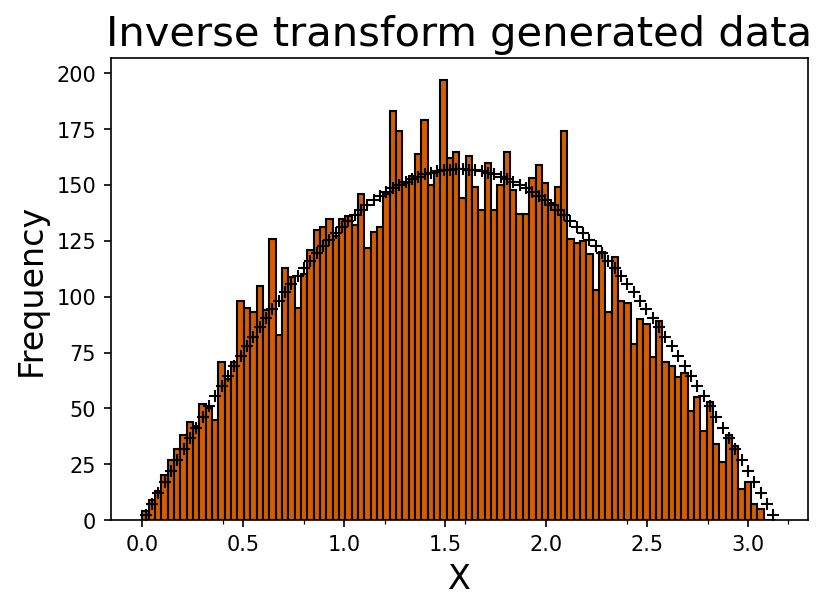

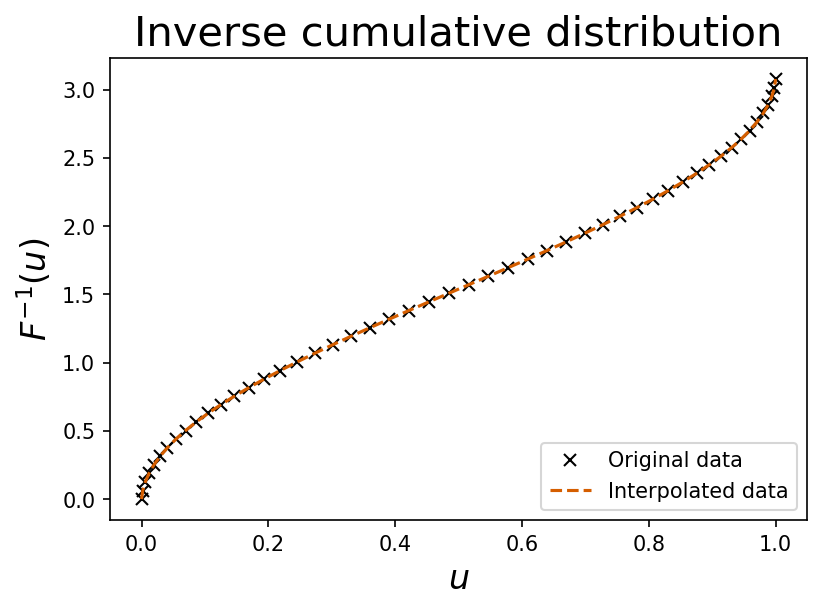

In [42]:
#%%timeit 
# Numerical inverse

# Define X points for numerical evaluation
# Generate uniform samples

# Use limits of range of X values and number of smaple set above.

# Generate X values IN ASCENDING ORDER and corresponding y values to use in the region of interest
number_interpolation_points = 50

X_interpolation = np.linspace(x_min, x_max, num=number_interpolation_points, endpoint=False ) # end point close to 0, cubic spline gets upset

# ANNOYING POINT. The last y_value is y=sin(\pi)=0 so is so close to zero that CubicSpline gets upset.
y_interpolation = np.sin(X_interpolation) # Note not normalised 

y_cumsum = y_interpolation.cumsum()    # This is not yet normalised and note leave off last value
ycdf = y_cumsum/y_cumsum[-1] # Use the last value to normalise CDF values 

# Interpolate the inverted function. Note the order of the arguments CubicSpline(ycdf, X).
inv_numerical = CubicSpline(ycdf, X_interpolation)

# Now we have our numerical approximation of the inverse CDF in inv_numerical

# Generate uniform y samples in the region of interest using same number of sample as first example
samples = rng.uniform(0,1,size = number_samples)
 
# Apply inverted function to uniform samples

draws = inv_numerical(samples) # These are the X=F^{-1}(y) values for each y value 

# Plot histogram of samples
bins = np.linspace(x_min, x_max, 101) # split the X space into equal size bins

# Optional: Find exact theoretical cdf results for comparison using cdf(x) from previous code cell.

bin_centre=[(bins[b]+bins[b-1])/2 for b in range(1,len(bins))] # use midpoint to show expected result for each bin
exact_bin_value=[number_samples *(cdf(bins[b])-cdf(bins[b-1]) ) for b in range(1,len(bins))] # Use cdf to find expected number in each bin

fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
vals, bins, patches = ax.hist(draws,bins = bins,fc='#D55E00',edgecolor='black')

# This is the exct prediction for each bin from the pdf, comment it out if you want the raw results alone.
ax.plot(bin_centre,exact_bin_value, "+", color='k')

ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('Frequency',fontsize = 16)
ax.xaxis.set_minor_locator(MultipleLocator(0.4))
ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.set_title('Inverse transform generated data',fontsize = 20)

fig = plt.figure(figsize = (6,4), dpi=150) 
ax = fig.add_subplot(111)

ax.plot(ycdf,X_interpolation,'x', label='Original data',color='black')
ax.plot(ycdf,inv_numerical(ycdf),label='Interpolated data',ls='--',color='#D55E00')
ax.legend(loc='lower right')
ax.set_xlabel('$u$',fontsize = 16)
ax.set_ylabel('$F^{-1}(u)$',fontsize =16)
#ax.set_yscale('log') No log scale needed here
ax.set_title('Inverse cumulative distribution',fontsize = 20)




* Accept-Reject Method

1. Generate a random number $X$ from a uniform distribution over the range of the desired PDF
1. Generate a second random number $y$ from the uniform distribution $h(y)$ = $U(0,a)$ where $a$ is the maximum value of the function $f(X)$ within the range of $X$ values required.  
1. If $y \leq f(X)$, then accept this point; otherwise it is rejected
1. Repeat from (1) until you have the number of points you want.
1. The set of kept values are a set random values $\{X\}$ drawn from a probability distribution with pdf f(X) 

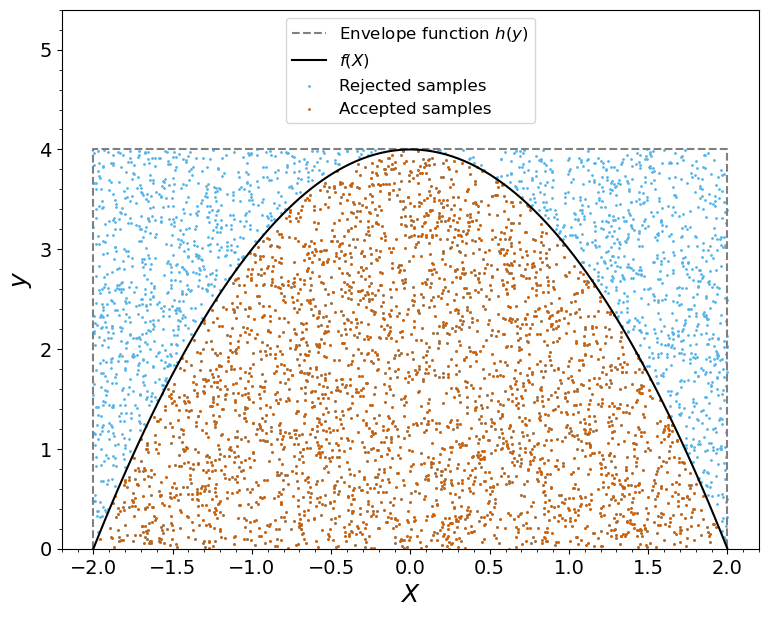

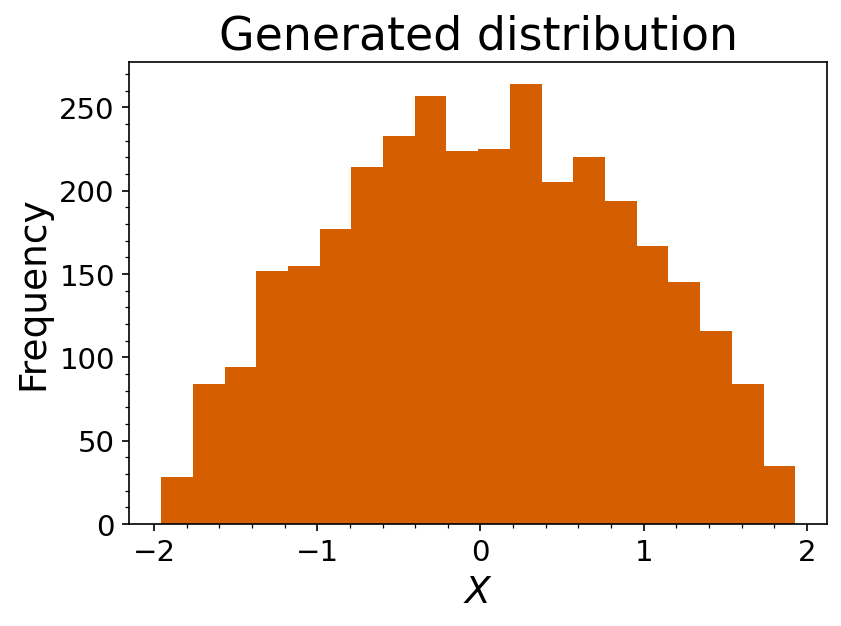

In [36]:
# Define the function. Note this is NOT normalised.
# Note for a more complicated function with discontinuities we just need more code with "if" statements
def f(x):
    return -x**2 + 4

# We want to generate values within the range X=-2..2. 
# We need $a$ the maximum value of $f(X)$ in that range which we set by hand
a_value = f(0.0)

# For reproducibility, I like to fix the seed for the random number generator, any number is as good as any other
rng = np.random.default_rng(0) 

# Generate uniform X samples in the region of interest
x_samples = rng.uniform(-2,2,size = 5000)

# Generate uniform y samples in U(0, max(f(X)) (where the max(f(X) here is at f(0))
y_samples = rng.uniform(0,a_value,size = 5000)

# Find which samples fulfill the criteria y <= f(X);
# This is an array of True and False values 
accept = (y_samples <= f(x_samples))

# Plot the PDF, envelope function, and some samples
fig, ax = plt.subplots(1,1,figsize = (9,7))
# Next draw box containing all the points which are drawn
ax.plot([-2,-2,2,2],[0,a_value,a_value,0],ls='--',color='grey',label='Envelope function $h(y)$')
# Next draw function
ax.plot(np.linspace(-2,2,100),f(np.linspace(-2,2,100)),label='$f(X)$',color='black')
ax.set_xlim(-2.2,2.2)
ax.set_ylim(0,1.35*a_value) # leave a little space at the top for the legend
ax.set_xlabel('$X$',fontsize = 18)
ax.set_ylabel('$y$',fontsize = 18)
ax.tick_params(labelsize = 14,which='both')
# Next plot ALL the points tried as failed points 
ax.scatter(x_samples, y_samples, s = 1, label='Rejected samples', color='#56B4E9')
# but then for the points we accept we plot another point to indicate accepted points as this will be on top and seen by us
ax.scatter(x_samples[accept],y_samples[accept],s = 1,c='#D55E00',label = 'Accepted samples')
ax.legend(loc='upper center',fontsize = 12)
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))



fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.hist(x_samples[accept], bins = 20,color='#D55E00')
ax.set_xlabel('$X$',fontsize = 18)
ax.set_ylabel('Frequency',fontsize = 18)
ax.tick_params(labelsize = 14,which='both')
ax.set_title('Generated distribution',fontsize = 22)
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(10))


# Week 2: Hypothesis Testing

Consider some hypothesised PDF $f(X)$ for a continuous variable $X$, and a single measurement (data point) $X_m$. 

* If the hypothesis is correct (i.e. that the random variable $X$ is distributed according to $f(X)$), then we expect the measurement $X_m$ to be in a region where the PDF is large
* If the measured value $X_m$ lies in a region of the PDF with low probability, we would reject the hypothesis that this random variable is distributed according to this PDF


- Cannot prove a hypothesis is true: even if $X_m$ at highest point of PDF

TYPE-1 ERRORS AND GOODNESS OF FIT

* Type-1 error: reject a true null hypothesis
<br>
We define a critical region (rejection region) which is a range of values of $X_m$ for which we would reject the null hypothesis. The probability of a measurement falling in the critical region, assuming the null hypothesis is true, is called the type-I error rate (significance level) and often we give it the label $\alpha$:

\begin{equation*}
\alpha = \int_{\text{critical region}}f(X) \, dX
\end{equation*}

** $\alpha$ is the percent of the total area (1) under the f(X) graph **

TEST STATISTICS

* The $\chi^2$ goodness of fit test

Define the $\chi^2$ test statistic given the measurements $y_i$, as the sum of the square of the residuals:

\begin{equation*}
\chi^2(y_i) = \sum_i p_i^2 = \sum_i \frac{(y_i - f(X_i))^2}{(\sigma_i)^2},
\end{equation*}

We can identify the null hypothesis ($H_0$) as the hypothesis that $f(X)$ describes the data well. 

We expect the square of each residual $p_i^2 \sim 1$, so the $\chi^2$ value for a good fit should be $\sim N_\text{data}$ i.e. similar to the number of data points.
In practice, we actually need to compare to the number of degrees of freedom $N_\text{dof}$, which is the difference between the number of data points $N_\text{data}$ and the number of fit parameters $N_\text{params}$:

\begin{equation*}
N_\text{dof} = N_\text{data} - N_\text{params}
\end{equation*}

* Define the **reduced chi-square statistic** $\chi_\nu^2$
$$
\chi^2_\nu = \frac{\chi^2}{N_\text{dof}}
$$
which is the $\chi^2$ per degree of freedom.

* If $\chi_\nu^2$ is around 1.0 then we may have a good fit.
<br>
<br>    
* For values of $\chi_\nu^2$ much greater than 1, average deviation is much greater than $1\sigma$:
    1. The chosen model could have too few parameters to model the data well; you could be **underfitting**.
    1. The choice of parameters $\boldsymbol{\theta}$ may not be correct even if the type of model is correct.
    1. The uncertainty on measurements $\sigma_i$ could be underestimated.
<br>
<br>
* For values of $\chi_\nu^2$ much less than 1, the average deviation is much less than $1\sigma$:
    1. The chosen model could have too many parameters for the data; you could be **overfitting**.
    1. The uncertainty on each data point could be overestimated.
 
Chi-square distribution

This tells you how to interpret the chi-square statistic according to your rejection region:


<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
C:\Users\ac5222\AppData\Local\Temp\ipykernel_17748\2042120317.py:11: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(X, chi2.pdf(X, 5), label='$\chi^2$ with 5 degrees of freedom',color='black',zorder = 1)
C:\Users\ac5222\AppData\Local\Temp\ipykernel_17748\2042120317.py:23: SyntaxWarning: invalid escape sequence '\c'
  ax.set_xlabel('$\chi^2$')
C:\Users\ac5222\AppData\Local\Temp\ipykernel_17748\2042120317.py:24: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('f($\chi^2$; 5)')


p-value = 17.72


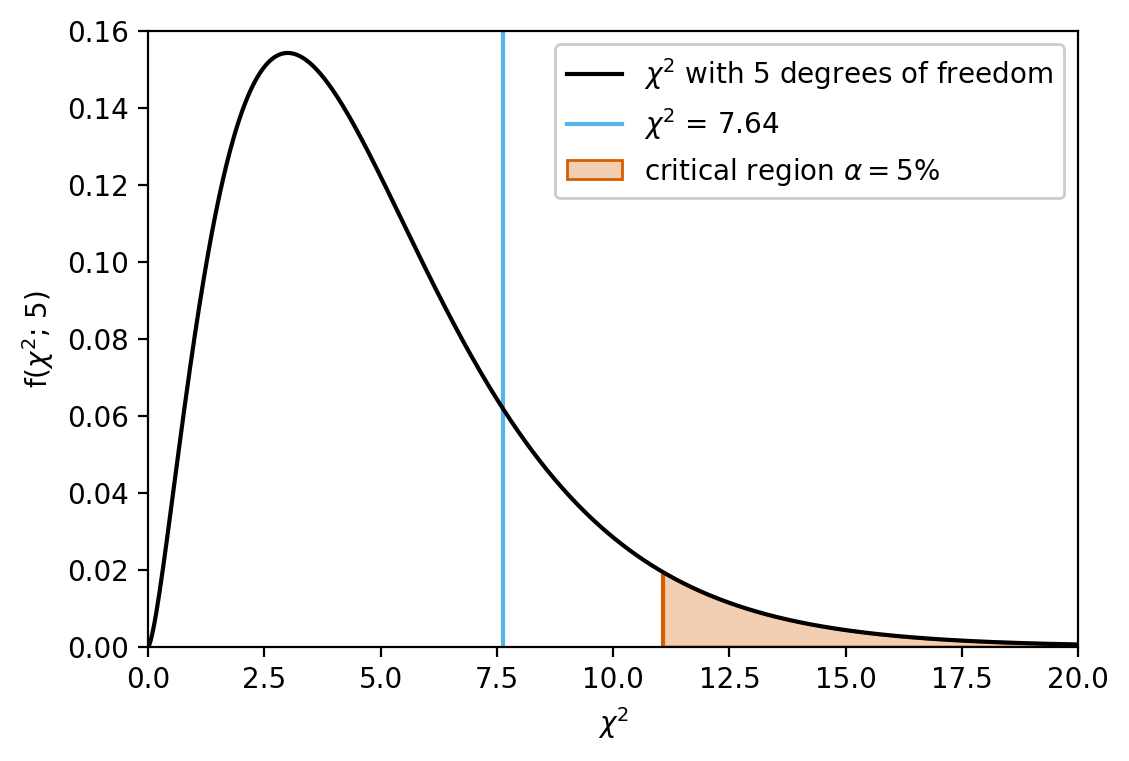

In [1]:
from scipy.stats import chi2 # This is the chi-square distribution, not the chi-square statistic
from matplotlib.colors import to_rgba
import numpy as np
import matplotlib.pyplot as plt

chi2_value = 7.64

X = np.linspace(0,20,1000)
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 200)

ax.plot(X, chi2.pdf(X, 5), label='$\chi^2$ with 5 degrees of freedom',color='black',zorder = 1)
ax.plot([chi2_value, chi2_value],[0,0.17],color='#56B4E9',zorder = 0, label=r'$\chi^2$ = {:4.2f}'.format(chi2_value))

#find and shape the alpha region
ax.plot([chi2.ppf(0.95,5),chi2.ppf(0.95,5)],[0,chi2.pdf(chi2.ppf(0.95,5),5)-0.001],zorder = 0,color='#D55E00')
ax.fill_between(np.linspace(chi2.ppf(0.95,5),25,1000),np.repeat(0,1000)
	,chi2.pdf(np.linspace(chi2.ppf(0.95,5),25,1000),5),fc=to_rgba('#D55E00',0.3)
	,label='critical region $\\alpha = 5$%',edgecolor='#D55E00',zorder = 0)

ax.set_ylim(bottom = 0, top = 0.16)
ax.set_xlim(0,20)
ax.legend(loc='upper right',framealpha = 1)
ax.set_xlabel('$\chi^2$')
ax.set_ylabel('f($\chi^2$; 5)')

p_value = chi2.sf(chi2_value,5) * 100
print(f"p-value = {p_value:.2f}")

- Calculate chi value - if in critical region, reject f(X) as model

A **p-value** yields the probability $p$ of getting the observed value of some test-statistic $t$ or larger (typically the null hypothesis). The statistic value $t$ is calculated from the data. The probability distribution used to find $p$ is the distribution for the test statistic given that the data comes from null model, our null hypothesis $H_0$. 

If the the probability density distribution for the possible test statistic values is written as $p(t|H_0)$ (indicating this is the probability for $t$ assuming $H_0$ is true) and if larger $t$ values are worse, then the p-value is simply found from the CDF     
$$
p = P(t|H_0) = \int_t^\infty dt' \,  p(t'|H_0) \, .
$$


### KS TEST

- **one-sample**: How likely data from reference probability distribution
- **two-sample**: how likely two sets of data if drawn from same (unknown) probablity distribution

Based around CDF: (Empirical CDF defined below)

In [ ]:
# This code cell creates the data
from scipy.stats import norm
import numpy as np

# Set the random seed for consistency. scipy.stats uses the numpy random number generator, so why not use 0?
np.random.seed(0) 


number_values = 50 # this is the number of data values to use 
samples = norm.rvs(loc=0.0, scale=1.0, size = number_values) # the mean is loc=0, the standard deviation is scale=1.0

def Fd(X):
    """ This gives the empirical cumulative distribution of the data in "samples" for given X value """
    return np.count_nonzero(samples<X)/len(samples)

# Values of X to use here when plotting
Xmin=-3.0
Xmax=3.0
Xvalues = np.linspace(Xmin, Xmax, number_values*2) 

empirical = [Fd(X) for X in Xvalues] # This gives the  empirical cumulative distribution for many values of X


**One sample** - 

\begin{equation*}
D = \max_X |F_\text{data}(X) - G(X)|,
\end{equation*}

large D --> worse agreement

In [ ]:
d1_D, d1_p = ks_1samp(samples, norm.cdf)

**Two sample** - 

\begin{equation*}
D_2 = \text{sup}_X|F_\text{data}(X) - G_\text{data}(X)|.
\end{equation*}

In [ ]:
ks_2samp(samples_normal_1, samples_normal_2)

### The Alternate Hypothesis

* Consider a random variable $X$
* Null hypothesis $H_0$: $X \sim f(X)$ for some probability distribution $f(X)$
* Alternate hypothesis $H_1$: $X \sim g(X)$ for some different probability distribution $g(X)$
* Make a measurement $X_m$ of the random variable $X$ that lies in a low PDF region for the null hypothesis
* Even if $f(X_m)$ is small, if $g(X_m)$ is *smaller* we say the null hypothesis is still still more believable than the alternate hypothesis, so we cannot reject the null hypothesis

Region where g(X) smaller than f(X) - remove from critical region e.g. two tailed becomes one tailed

Note: much like before, we *cannot* accept the alternate hypothesis under a hypothesis test, only decide whether we do or do not reject the null hypothesis. 

**power**  

\begin{equation*}
1-\beta = \int_{\text{critical region}}g(X) \, dX
\end{equation*}

probability that we would reject the null hypothesis (that $X$ lies in the critical region) when the alternate hypothesis is true

Area under the g(X) with critical alpha limits

**type-II error rate**, which is the probability that we would **not** reject the null hypothesis when the alternate hypothesis is true 

In modern hypothesis tests, we want to choose the critical region under two constraints, 

1. The value of the type-I error is equal to the desired value of $\alpha$ (for example 5%)
2. The power $1-\beta$ is as large as possible (or equivalently, the type-II error is as small as possible)

#### SUMMARY

The chi squared **statistic** is the single number that describes how well a model fits a distribution.

The chi squared **distribution** is the graph (dependent on degrees of freedom) that tells us how to interpret the chi squared statistic (it gives you the probability of getting a certain chi squared statistic for a specific number of degrees of freedom). 

So we look at the graph, decide our rejection region (this is alpha)(in terms of % probability) and check whether our stat is less than the corresponding cutoff. Remember that alpha refers to the area under the graph (it's a probability), so you need to check what chi squared statistic corresponds to the alpha (eg 5%) cutoff. You can also do this the other way round using the p-value: this is when you calculate the area under the graph starting at your calculated chi squared statistic, this corresponds to the probability of getting a chi sqaured statistic greater than or equal to yours. If your p-value is GREATER than alpha, then you ACCEPT. But if your p-value is LESS than alpha, this means that you had a less than 5% (or whatever your alpha is) chance of getting that value, so you REJECT your null hypothesis.

KOLMOGOROV-SMIRNOV TESTS

The **one-sample** KS test compares a data sample with a reference probablity distribution. The question this test asks is
* how likely is it that we would see these data samples if the data is drawn from that probability distribution?

The **two-sample** KS test compares two different data samples. This test asks
* how likely is it that we would see these two sets of data samples if they are drawn from the same (but unknown) probability distribution?

# Week 3: Likelihoods

$$
L(H) = f(X|H)
$$

$$
\ln L(H) = \ln \prod_{i}^{N}f(X_{i}|H) = \sum_{i=1}^{N} \ln f(X_{i}|H)
$$

Binned Likelihood: Product of Poisson distributions

<b>Likelihood Ratio Tests:<b>

Define critical region c' for which

$$
\int_{c^{\prime}} f(X|H_{0}) dX = \alpha
$$

where $f(X|H_{0})$ is the probability distribution for our measured values of $X$

Define the power of the test as,

$$
\int_{c^{\prime}} f(X|H_{1}) dX = 1-\beta
$$

For a specific value of $\alpha$, we want to find the region $c^{\prime}$ for the data space where this power will be maximised. 


The likelihood ratio statistic is:

$$
\Lambda = \frac{L(H_0)}{L(H_1)}
$$

Taking the **log-likelihood ratio**:

$$
-\ln(\Lambda) = - \left( \ln L(H_0) - \ln L(H_1) \right)
$$

- If $( H_0 )$ is true, we expect $ -\ln(\Lambda) $ to be **small**.
- If $( H_1 )$ is true, we expect $ -\ln(\Lambda) $ to be **large**.
- We reject $( H_0 )$ when $ -\ln(\Lambda) $ is **too large**, meaning the data is much more likely under $ H_1 $ than under $H_0 $.

Thus, the rejection region is **only in the upper tail** of the $-\ln(\Lambda) $ distribution under $ H_0 $.


In [ ]:
# LOG LIKELIHOOD OF NULL AND ALT HYPOTHESIS EXAMPLE

import pandas as pd 
from scipy.stats import norm
from scipy.stats import multivariate_normal

import numpy as np

# null hypothesis is a single source - multi normal Gaussian 
mu_H0_x=mu_H0_y=mu_H0_z = 0
sigma_H0_x=sigma_H0_y=sigma_H0_z = 1

# alt hypothesis is a different single source - multinormal Gaussian 
mu_H1_x = 0.5
mu_H1_y = -0.3
mu_H1_z = 0.2

sigma_H1_x = 0.4 
sigma_H1_y = 0.3
sigma_H1_z = 0.7

# correlations 
rXY = 0.3
rXZ = 0.6
rYZ = 0.5 




# Define the two hypotheses in terms of their probability densities for the multivariate random variabe (X,Y,Z)

def makeCovariance(sx,sy,sz):
    cov = [  [sx**2    , rXY*sy*sz, rXZ*sx*sz]
            ,[rXY*sy*sz, sy**2,     rYZ*sz*sy]
            ,[rXZ*sx*sz, rYZ*sz*sy, sz**2    ]
    ]
    return cov

pH0 = multivariate_normal([mu_H0_x,mu_H0_y,mu_H0_z], makeCovariance(sigma_H0_x,sigma_H0_y,sigma_H0_z))
pH1 = multivariate_normal([mu_H1_x,mu_H1_y,mu_H1_z], makeCovariance(sigma_H1_x,sigma_H1_y,sigma_H1_z))

print(pH0.logpdf([1,4,2]))





data_multivariate = pd.read_csv('multivariate_data.csv')
data_multivariate_H0 = data_multivariate[data_multivariate['Hypothesis']==0]
data_multivariate_H1 = data_multivariate[data_multivariate['Hypothesis']==1]

# turn the dataframes into 
data_multivariate_H0 = data_multivariate_H0[['X','Y','Z']].to_numpy()
data_multivariate_H1 = data_multivariate_H1[['X','Y','Z']].to_numpy()



#PLOTS THE LOG LIKELIHOODS FOR EACH SET OF DATA 


import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=140)

nLogLH0 = pH0.logpdf(data_multivariate_H0)-pH1.logpdf(data_multivariate_H0) 
nLogLH1 = pH0.logpdf(data_multivariate_H1)-pH1.logpdf(data_multivariate_H1)

ax.hist(nLogLH0,bins=200,histtype='step',label='H0',color='blue',density=True)
ax.hist(nLogLH1,bins=200,histtype='step',label='H1',color='orange',density=True)
ax.set_xlabel("$-\\ln(\\Lambda)$",fontsize=14)
ax.set_xlim(-5,60)
ax.set_yscale('log')
ax.legend()







#FINDS THE AREA H0 AND H1 FOR A MANY THRESHOLDS (CRITICAL VALUE) TO CALCULATE THE TYPE I AND II ERRORS 

# plot ROC curve 
thresholds = np.linspace(-5,20,100)
alphac = [len(nLogLH0[nLogLH0<lnLmax])/len(nLogLH0) for lnLmax in thresholds]
ombetac = [len(nLogLH1[nLogLH1<lnLmax])/len(nLogLH1) for lnLmax in thresholds]

fig,ax = plt.subplots(1,1,figsize=(5,4),dpi=140)
ax.plot(alphac, ombetac, color='black',label= "$-\\ln(\\Lambda)$ ROC curve")
ax.set_xlabel("$\\alpha$",fontsize=14)
ax.set_ylabel("$1-\\beta$",fontsize=14)
ax.legend()


'''METHOD

1. DEFINE TWO HYPOTHESIS IN TERMS OF PROB DENSITIES
2. FIND LOG LIKELIHOOD OF EACH POINT IN EACH SET OF DATA (H0 AND H1 SEPARATED DATA) --> H0 = LOG(PDFH0(H0)) - LOG(PDFH1(H0))
3. GOING UP IN THRESHOLD CALCULATE ALPHA AND 1-BETA FOR EACH 
    ALPHA = SUM(NUMBER OF LOGLIKELIHOODH0 < THRESHOLD ) / LENGTH(LOGLIKELIHOOD H0)
    BETA = SUM(NUMBER OF LOGLIKELIHOODH1 < THRESHOLD ) / LENGTH(LOGLIKELIHOOD H1)
'''

# Week 4: Parameter Estimation

<b> Good estimates <b>



<br>
Many methods of estimation exist, where some are better than others. Good estimates are:

1. Consistent: in the limit of large N, $\hat{\theta} \to \theta$ i.e. the estimate converges to the true value
<br>

1. Unbiased: $E(\hat{\theta})  = \theta$ i.e. the expectation of the estimate equals the true value
<br>

1. Efficient: $V(\hat{\theta})$ is small, i.e. the variance in the estimate is small.

The expectation value $E(\ldots)$ and the variance $V(\ldots)$ shown here come from where we imagine that same identical experiment is done by many different people. The expectation and variance is found by looking at how the results vary from person to person. 

<b> chi-squared estimation method: <b>

* Consider some data $\{X_i\}$ that we hypothesise is modelled by some function $f(X_i; \theta)$ with one parameter $\theta$
* By finding a minimum of the $\chi^2$ with respect to $\theta$, we can choose the best estimate $\hat{\theta}$ to describe our data
* To minimise $\chi^2$ with respect to $\theta$, we require:
\begin{align*}
\frac{\partial\chi^2}{\partial\theta} &= 0 \\
\frac{\partial^2 \chi^2}{\partial\theta^2} &\gt 0
\end{align*}

where the first condition requires that we are at a stationary point of the $\chi^2$ function with respect to $\theta$, and the second condition requires that said stationary point is a minimum.

<b> Maximum Likelihood Estimation Method <b>

- Series of N measurements, data points $X_i$ that are samples from whatever probability distribution underlies the quantity we are measuring.
- Define the total probability of our measurements as the product of the probablity of each individual measurement:

$$
L(\theta; X_i) = \prod_{i = 1}^Nf(X_i;\theta),
$$

$$

\ln L(\theta; X_i) = \sum_{i = 1}^N\ln f(X_i;\theta),
$$


**Maximum Likelihood Principle**: the values of the parameters that maximise the log-likelihood function are the best estimates of those parameters

\begin{align*}
\frac{\partial\ln(L)}{\partial\theta_j} &= 0 \\
\frac{\partial^2\ln(L)}{\partial\theta_j^2} &\lt 0 
\end{align*}

<b> Example Fitting: <b>

In [ ]:
x_values = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

y_measured = [343.39452514, 251.31914561, 186.7806368, 121.30027965, 45.23336652, 
              23.49470302, 18.46581766, 6.58329486, 1.98522328, -6.74799454, 
              -7.55489379, -29.55544088, -31.32898172, -36.27525348, -25.23860169, 
              -1.09156819, 52.32898397, 225.38126087, 460.67437131]

y_err = [141.312, 86.205, 49.632, 26.877, 13.872, 
         7.197, 4.08, 2.397, 0.672, 1.923, 5.568, 
         9.795, 13.488, 14.883, 11.568, 0.483, 
         22.08, 60.477, 119.712]


In [ ]:
import iminuit 
from iminuit.cost import LeastSquares 
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit


def line_np(x, par):
    return np.polyval(par, x)  # polynomial function (par is the coefficients of the polynomial - number of par = polynomial order + 1)

least_squares_np = LeastSquares(x_values, y_measured, y_err, line_np)


## ESTIMATE M AND C -- errors are small around values at indices 8 and 9 ##
m_est = (y_measured[9]-y_measured[8])/(x_values[9]-x_values[8])
c_est = y_measured[8] - m_est*x_values[8]


N_list=[1,2,3,4,5,6,8] # order of polynomial, maximum power is x^N where N=N_list[i]


## SET UP MINUIT OBJECTS AND FIT DATA ##

mobj_list = [] # list of the Minuit objects - one for each polynomial order
for N in N_list:
    print ("Fitting order {:d} polynomial".format(N))

    #INITIAL PARAMTER SET UP
    if N == 1:
        initial_argument_list = [m_est, c_est]
    else:
        # First set the initial parameter values to be [0,0, ..., m_est,c_est]
        # Length of this initial parameter value list sets the order of polynomial fitted
        initial_argument_list = [0]*N # Set all coefficient values of polynomial to be zero 
        initial_argument_list[-1] = c_est # set last one equal to c estimate
        initial_argument_list[-2] = m_est # set second last one equal to c estimat
        
        # Now define Minuit object then minimise
        mobj = Minuit(least_squares_np, initial_argument_list)
        mobj.migrad() # No graphical output produced here by default 
        mobj.hesse() 
        mobj_list.append(mobj)
    
    
    
## PLOTTING DATA AND FITS ##

fig = plt.figure(dpi = 150,figsize = (6,4))
ax = fig.add_subplot()
ax.errorbar(x_values, y_measured, yerr = y_err, color='#000000',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)

x_min = min(x_values)
x_max = max(x_values)
fit_x_values = np.linspace(x_min,x_max,100)

# for each fit, plot a line
for fit_number in range(len(mobj_list)):

    mobj = mobj_list[fit_number]
    fit_param_values = [ v for v in mobj.values]
    fit_y_values = line_np(fit_x_values, fit_param_values)

    ax.plot( fit_x_values, fit_y_values, label=str(N_list[fit_number]) )
 

plt.legend(loc='best')


Goodness of Fit:

In [ ]:
from scipy.stats import chi2 # This is the chi-square distribution, not the chi-square statistic
from matplotlib.ticker import MultipleLocator

N_list=range(2,20) 

mobj_list = [] 
chir_list=[]
pvalue_list=[]

for N in N_list:

    initial_argument_list = [0] * N 
    initial_argument_list[-1] = c_est 
    initial_argument_list[-2] = m_est 
    
    # Now define Minuit object then minimise
    mobj = Minuit(least_squares_np, initial_argument_list)
    mobj.migrad() 
    mobj.hesse() 
    mobj_list.append(mobj)
    chir_list.append(mobj.fmin.reduced_chi2)

    pvalue = chi2.sf(mobj.fval, mobj.ndof) #P-VAL CALC
    pvalue_list.append(pvalue)
    
for iii in range(len(N_list)):    
    N = N_list[iii]
    print ("Fitting order {:d} polynomial".format(N)
           +f" reduced chi square = {chir_list[iii]:.2f}, p-value is {pvalue_list[iii]:5.3f}")


#GRAPHS
fig, ax = plt.subplots(1,2,figsize = (12,4))

ax[0].set_xlabel(r'$N$',fontsize = 16)
ax[0].set_ylabel(r'$\chi^2_r$',fontsize = 16)
ax[0].scatter(N_list,chir_list,color='#D55E00')

ax[0].tick_params(direction='in',top=True,right=True,which='both',labelsize =12)
ax[0].xaxis.set_minor_locator(MultipleLocator(0.2))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.01))
#ax[0].legend() #(loc='upper left')
ax[0].set_title('reduced chi square',fontsize = 20)
ax[0].grid('xkcd:dark blue',alpha = 0.2)

ax[1].set_xlabel(r'$N$',fontsize = 16)
ax[1].set_ylabel(r'$p$-value',fontsize = 16)
ax[1].scatter(N_list,pvalue_list,color='#D55E00')

ax[1].tick_params(direction='in',top=True,right=True,which='both',labelsize =12)
ax[1].xaxis.set_minor_locator(MultipleLocator(0.2))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.01))
#ax[1].legend() #(loc='upper left')
ax[1].set_title('p value',fontsize = 20)
ax[1].grid('xkcd:dark blue',alpha = 0.2)

fig.tight_layout()

Good fit:
- reduced chi squared ~ 1
- large p-value 
    - p-value measures prob that the observed data could occur under assumed model

**Uncertainties and cost function**

In [ ]:
mobj1 = mobj_list[0] # 1st order polynomial
for param in mobj1.params:
    print('{} = {:.2f} +/- {:.2f}'.format(param.name, param.value, param.error))

mobj1.draw_profile("x1")


<b> Unbinned and binned <b>

unbinned - need normalised PDF of model:

\begin{equation*}
f(X; z, \mu, \sigma) = zf_{\text{normal}}(X; \mu, \sigma) + (1 - z)f_{\text{uniform}}(X)
\end{equation*}
- z=weighting factor

In [ ]:
from scipy.stats import norm, uniform
from matplotlib.colors import to_rgba
from matplotlib.ticker import MultipleLocator
from iminuit.cost import UnbinnedNLL
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

xrange = -1, 1
rng = np.random.default_rng(1)

mu_value = 0.0
sigma_value = 0.1
n_normal = 400
n_uniform = 1000
z_value =  n_normal/(n_normal+n_uniform)

x_data = rng.normal( mu_value, sigma_value, size = n_normal) 
x_data = np.append(x_data, rng.uniform(*xrange, size = n_uniform))

counts, bin_edges = np.histogram(x_data, bins = 50, range = xrange)
x_bin_centre = 0.5*(bin_edges[1:]+bin_edges[:-1])
dx = np.diff(bin_edges)

## PLOTTING DATA AND ERRORS IN BAR CHART ##
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.bar(x_bin_centre, counts, yerr = counts**0.5, 
       width = dx,
       fc=to_rgba('#D55E00',0.3),edgecolor='black',
       error_kw={'ecolor':'#D55E00','capsize':2,'elinewidth':1,'capthick':1})
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Frequency',fontsize = 16)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(4))


## DEFINING MODEL PDF, COST FUNCTION AND MINUIT FIT ##
def model_pdf(x, z, mu, sigma):
    return (z*norm.pdf(x, mu, sigma) + (1-z)*uniform.pdf(x, xrange[0], xrange[1]-xrange[0]))

cost_function = UnbinnedNLL(x_data, model_pdf) # only need to pass the samples we have

m_obj = Minuit(cost_function, z = 0.4, mu = 0, sigma = 0.2) # arbitrary starting parameters
m_obj.limits['z'] = (0,1) # Set limit on z
m_obj.limits['mu'] = (-1, 1) # Set limit on mu
m_obj.limits['sigma'] = (0, None) # Set lower limit on sigma

m_obj.migrad()

## PLOTTING FITTED PDF AND DATA ##

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi = 150)
ax.errorbar(x_bin_centre, counts, counts**0.5, fmt='ok',ms = 5,capsize = 2,zorder = 0)

xm = np.linspace(bin_edges[0],bin_edges[-1],1000)
ax.plot(xm, model_pdf(xm, *[p.value for p in m_obj.init_params])*len(x_data)*dx[0], 
             ls = ':', label='Initial parameter values',color='#D55E00',zorder = 1)
ax.plot(xm, model_pdf(xm, *m_obj.values)*len(x_data)*dx[0], 
             label='Fit',color='#56B4E9',zorder = 1)
ax.legend(loc='upper right')
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Freqeuncy',fontsize = 16)
ax.set_title('Unbinned maximum-likelihood fit',fontsize = 20)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(4))
ax.tick_params(direction='in',which='both',top=True,right=True)

## ERROR CALCULATION ##

hhh = m_obj.hesse() # calculate parameter uncertainties

for param in m_obj.params:
    print('{} = {:.2f} +/- {:.2f}'.format(param.name, param.value, param.error))



Binned: 
- more computationally efficient and numerically stable
- need to choose appropriate binning, not unique
    - need to retain all information without having too few counts per bin (can cut off very small bins - noise)
- need to provide CDF instead
- cost function = sum of poissons (each bin is a poisson)


In [ ]:
from iminuit.cost import BinnedNLL

## BINNED CDF, COST FUNCTION AND MINUIT FIT ##
def model_cdf(xe, z, mu, sigma):
    return (z * norm.cdf(xe, mu, sigma) +
            (1-z) * uniform.cdf(xe, xrange[0], xrange[1] - xrange[0]))

bnll_cost_function = BinnedNLL(counts, bin_edges, model_cdf)

bnll_mobj = Minuit(bnll_cost_function, z = 0.4, mu = 0, sigma = 0.2)

bnll_mobj.limits['z'] = (0,1)
bnll_mobj.limits['mu'] = (-1,1)
bnll_mobj.limits['sigma'] = (0, None)

bnll_mobj.migrad()


## ERRORS ##
hhh = bnll_mobj.hesse() # calculate parameter uncertainties

for param in bnll_mobj.params:
    print('{} = {:.2f} +/- {:.2f}'.format(param.name, param.value, param.error))


## PLOTTING FITTED PDF AND DATA ##
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.errorbar(x_bin_centre, counts, counts**0.5, fmt='ok',ms = 5,capsize = 2,zorder = 0)
ax.stairs(np.diff(model_cdf(bin_edges, *[p.value for p in bnll_mobj.init_params]))*len(x_data), 
          bin_edges, 
          ls=':',label='Initial parameter values',zorder = 1,color='#D55E00')
ax.stairs(np.diff(model_cdf(bin_edges, *bnll_mobj.values))*len(x_data), bin_edges, 
          label='Fit',zorder = 1,color='#56B4E9')
ax.set_xlabel('$X$',fontsize = 16)
ax.set_ylabel('Frequency',fontsize = 16)
ax.set_title('Binned maximum-likelihood fit',fontsize = 20)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(4))
ax.legend(loc='upper right')
ax.tick_params(labelsize = 12, direction='in',top=True,right=True,which='both')

# Week 5: k-NN Testing and SVC

 ### **KNN Classification**

/var/folders/pw/d23366lj4q933d83b9n0xfwm0000gn/T/ipykernel_49773/2672262835.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  knn_df = pd.concat([knn_df,pd.DataFrame([model_dict])])


,n_neighbors,weights,test_accuracy,auc_score,mean_cv_score
0,10,uniform,0.925,0.973284,0.94500
0,10,distance,0.915,0.970209,0.94625
0,30,uniform,0.920,0.978526,0.94500
0,30,distance,0.925,0.976510,0.94000
0,60,uniform,0.925,0.980492,0.94375
0,60,distance,0.925,0.979030,0.93875
0,85,uniform,0.925,0.980794,0.93625
0,85,distance,0.925,0.980542,0.93875
0,90,uniform,0.930,0.980492,0.93250
0,90,distance,0.925,0.980442,0.93750


Best scores for each metric:
╒═══════════════╤═══════════╤═════════════════╤═════════════╤═════════════════╕
│   n_neighbors │ weights   │   test_accuracy │   auc_score │   mean_cv_score │
╞═══════════════╪═══════════╪═════════════════╪═════════════╪═════════════════╡
│            90 │ uniform   │           0.93  │    0.980492 │         0.9325  │
├───────────────┼───────────┼─────────────────┼─────────────┼─────────────────┤
│            10 │ distance  │           0.915 │    0.970209 │         0.94625 │
├───────────────┼───────────┼─────────────────┼─────────────┼─────────────────┤
│            85 │ uniform   │           0.925 │    0.980794 │         0.93625 │
╘═══════════════╧═══════════╧═════════════════╧═════════════╧═════════════════╛


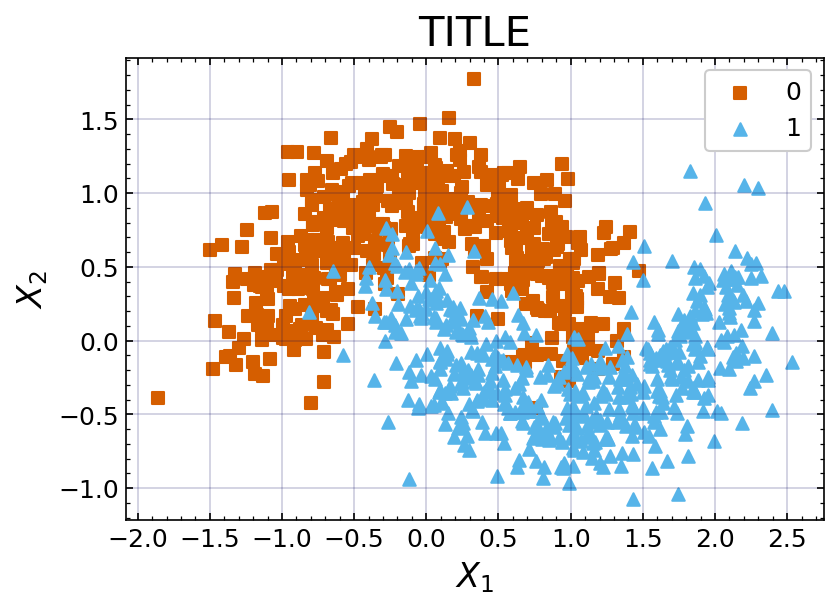

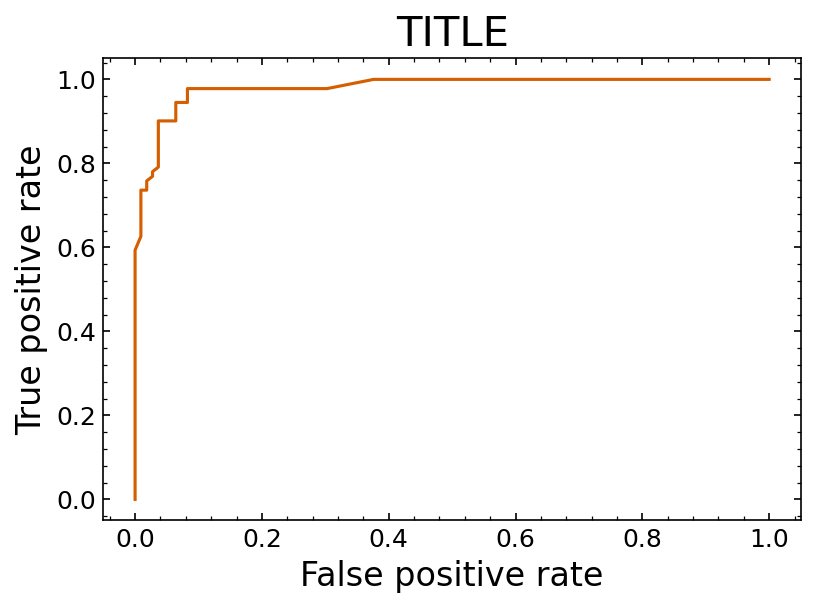

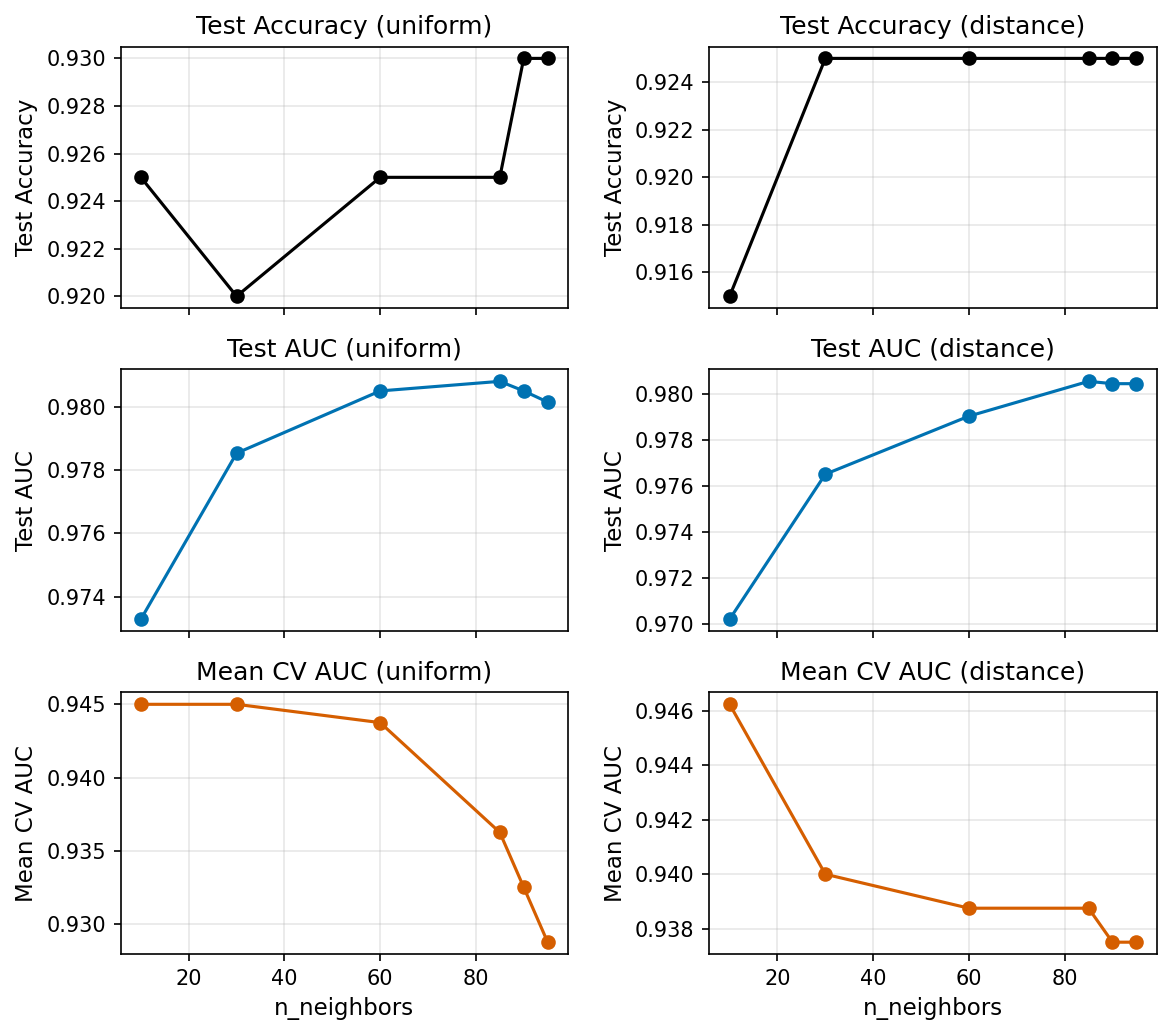

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from tabulate import tabulate

with open("PHYS60022_2m_n1000_r0250_s024.npy", 'rb') as ifp:
    coord = np.load(ifp)
    label = np.load(ifp)


# code to plot the data points
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.scatter(coord[:,0][label==0],coord[:,1][label==0],color='#D55E00',marker='s',label= '0',zorder = 1)
ax.scatter(coord[:,0][label==1],coord[:,1][label==1],color='#56B4E9',marker='^',label='1',zorder = 1)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',labelsize= 12,direction='in',top=True,right=True)
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend(loc='upper right',fontsize = 12,framealpha = 1)
ax.set_title('TITLE',fontsize = 20)



#import libraries needed
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.metrics import roc_curve




# set of hyperparameters to test
list_of_weights = ['uniform','distance']
list_of_neighbors = [10, 30, 60, 85, 90, 95]

list_of_hyperparameters = [(n, w) for n in list_of_neighbors for w in list_of_weights]

#define dataframe to dsiplay results 
knn_df = pd.DataFrame(columns=['n_neighbors','weights','test_accuracy','auc_score', 'mean_cv_score'])

# Split data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(coord, label, test_size = 0.2,random_state = 3) 



best_cv = 0
best_acc = 0
best_auc = 0

#looping through parameters
for neighbors, weights in list_of_hyperparameters:

    knn_model = KNeighborsClassifier(n_neighbors = neighbors, weights = weights) #define model
    knn_model.fit(X_train, y_train) #fit model


    y_pred = knn_model.predict(X_test) #predict test data
    acc = accuracy_score(y_test,y_pred) #calculate accuracy
    cv_score = cross_val_score(knn_model, X_train, y_train)

    y_score = knn_model.predict_proba(X_test)[:,1] #calculate scores of test data
    auc_score = roc_auc_score(y_test, y_score)



    #add hyperparameters and scores to data frame
    model_dict = {'n_neighbors':neighbors,
                  'weights':weights,
                  'test_accuracy':acc,
                  'auc_score':auc_score,
                  'mean_cv_score':cv_score.mean()}
                  
    knn_df = pd.concat([knn_df,pd.DataFrame([model_dict])])


    # save model with the highest cross-validation score
    if cv_score.mean() > best_cv:
        best_cv_model = knn_model
        best_cv = cv_score.mean()
        best_cv_hparam = np.array([neighbors, weights, acc, auc_score, cv_score.mean()])
    
    # save model with the highest accuracy
    if acc > best_acc:
        best_acc_model = knn_model
        best_acc = acc
        best_acc_hparam = np.array([neighbors, weights, acc, auc_score, cv_score.mean()])

    # save model with the highest auc
    if auc_score > best_auc:
        best_auc_model = knn_model
        best_auc = auc_score
        best_auc_hparam = np.array([neighbors, weights, acc, auc_score, cv_score.mean()])


display(knn_df)

print(f'Best scores for each metric:')
print(tabulate([best_acc_hparam, best_cv_hparam, best_auc_hparam],
                 headers=['n_neighbors','weights','test_accuracy','auc_score', 'mean_cv_score'],
                 tablefmt='fancy_grid'))



## ROC CURVE PLOTTING ##

y_pred = best_acc_model.predict(X_test)
y_score = best_acc_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.plot(fpr, tpr, color='#D55E00')
ax.set_xlabel('False positive rate',fontsize = 16)
ax.set_ylabel('True positive rate',fontsize = 16)
ax.xaxis.set_minor_locator(MultipleLocator(0.04))
ax.yaxis.set_minor_locator(MultipleLocator(0.04))
ax.tick_params(which='both',labelsize = 12, direction='in',top=True,right=True)
ax.set_title('TITLE',fontsize = 20)





#PLOTTING COMPARISON
fig, axs = plt.subplots(3, 2, figsize=(8, 7), dpi=150, sharex=True)

metrics = ['test_accuracy', 'auc_score', 'mean_cv_score']
titles = ['Test Accuracy', 'Test AUC', 'Mean CV AUC']
colors = ['black', '#0072B2', '#D55E00']

for col, weight in enumerate(['uniform', 'distance']):
    subset = knn_df[knn_df['weights'] == weight].sort_values('n_neighbors')
    x = subset['n_neighbors']

    for row, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
        ax = axs[row, col]
        ax.plot(x, subset[metric], marker='o', color=color)
        ax.set_title(f'{title} ({weight})', fontsize=12)
        ax.set_ylabel(title, fontsize=11)
        ax.grid(True, alpha=0.3)
        if row == 2:
            ax.set_xlabel('n_neighbors', fontsize=11)
        ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()


### **KNN Regression (From week 6)** 

/var/folders/pw/d23366lj4q933d83b9n0xfwm0000gn/T/ipykernel_49773/1255293805.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  knn_reg_df = pd.concat([knn_reg_df, model_result], ignore_index=True)


,n_neighbors,weights,MAE,MSE,RMSE,R2,KS-statistic,KS-p-value,CV-RMSE
0,1,uniform,6.932468,98.577463,9.928618,0.927230,0.25,0.571336,10.352812
1,1,distance,6.932468,98.577463,9.928618,0.927230,0.25,0.571336,10.352812
2,2,uniform,7.633051,98.068184,9.902938,0.927606,0.25,0.571336,9.050047
3,2,distance,6.902698,83.436573,9.134362,0.938407,0.20,0.831970,8.935246
4,3,uniform,6.994650,95.383673,9.766457,0.929588,0.20,0.831970,9.304492
5,3,distance,6.551456,69.610506,8.343291,0.948614,0.20,0.831970,8.868430
6,5,uniform,7.799487,148.768984,12.197089,0.890179,0.20,0.831970,11.069586
7,5,distance,6.269641,67.339013,8.206035,0.950290,0.15,0.983137,9.452254
8,6,uniform,8.214160,175.800793,13.258989,0.870224,0.20,0.831970,12.065017
9,6,distance,6.185966,67.496272,8.215612,0.950174,0.15,0.983137,9.663603


Best scores for each metric:
╒═══════════════╤═══════════╤═════════════════╤══════════╤══════════╕
│   n_neighbors │ weights   │   mean_cv_score │     rmse │       r2 │
╞═══════════════╪═══════════╪═════════════════╪══════════╪══════════╡
│            90 │ uniform   │         0.93    │ 0.980492 │ 0.9325   │
├───────────────┼───────────┼─────────────────┼──────────┼──────────┤
│            95 │ distance  │        -8.86843 │ 8.34329  │ 0.948614 │
├───────────────┼───────────┼─────────────────┼──────────┼──────────┤
│            85 │ uniform   │         0.925   │ 0.980794 │ 0.93625  │
╘═══════════════╧═══════════╧═════════════════╧══════════╧══════════╛


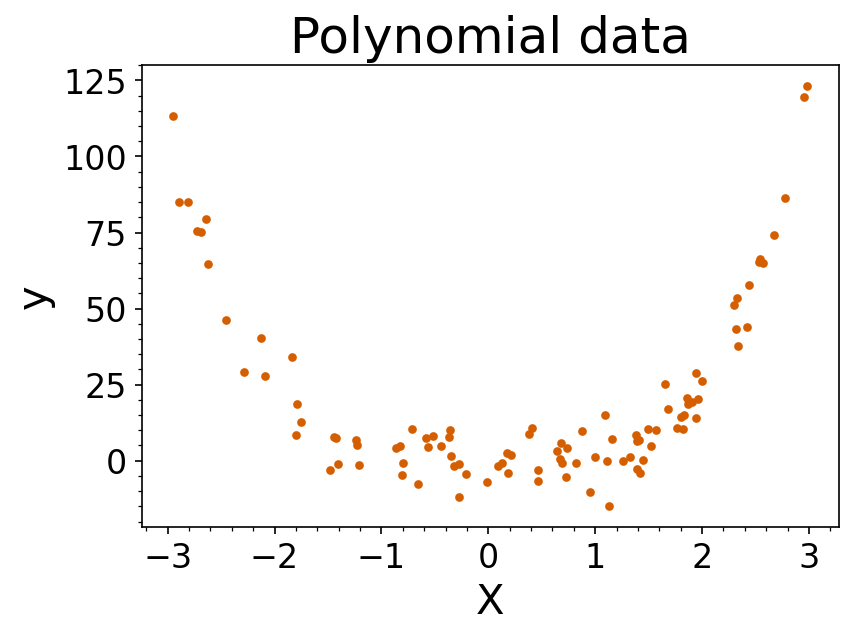

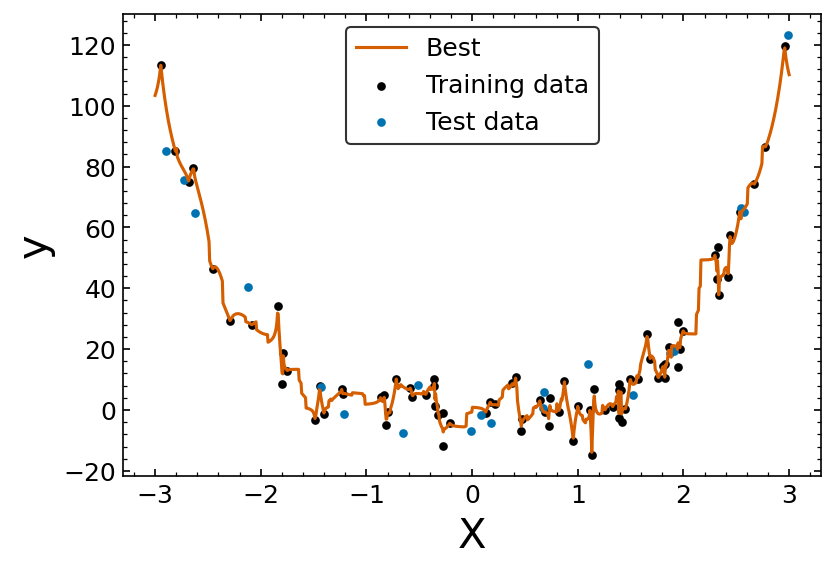

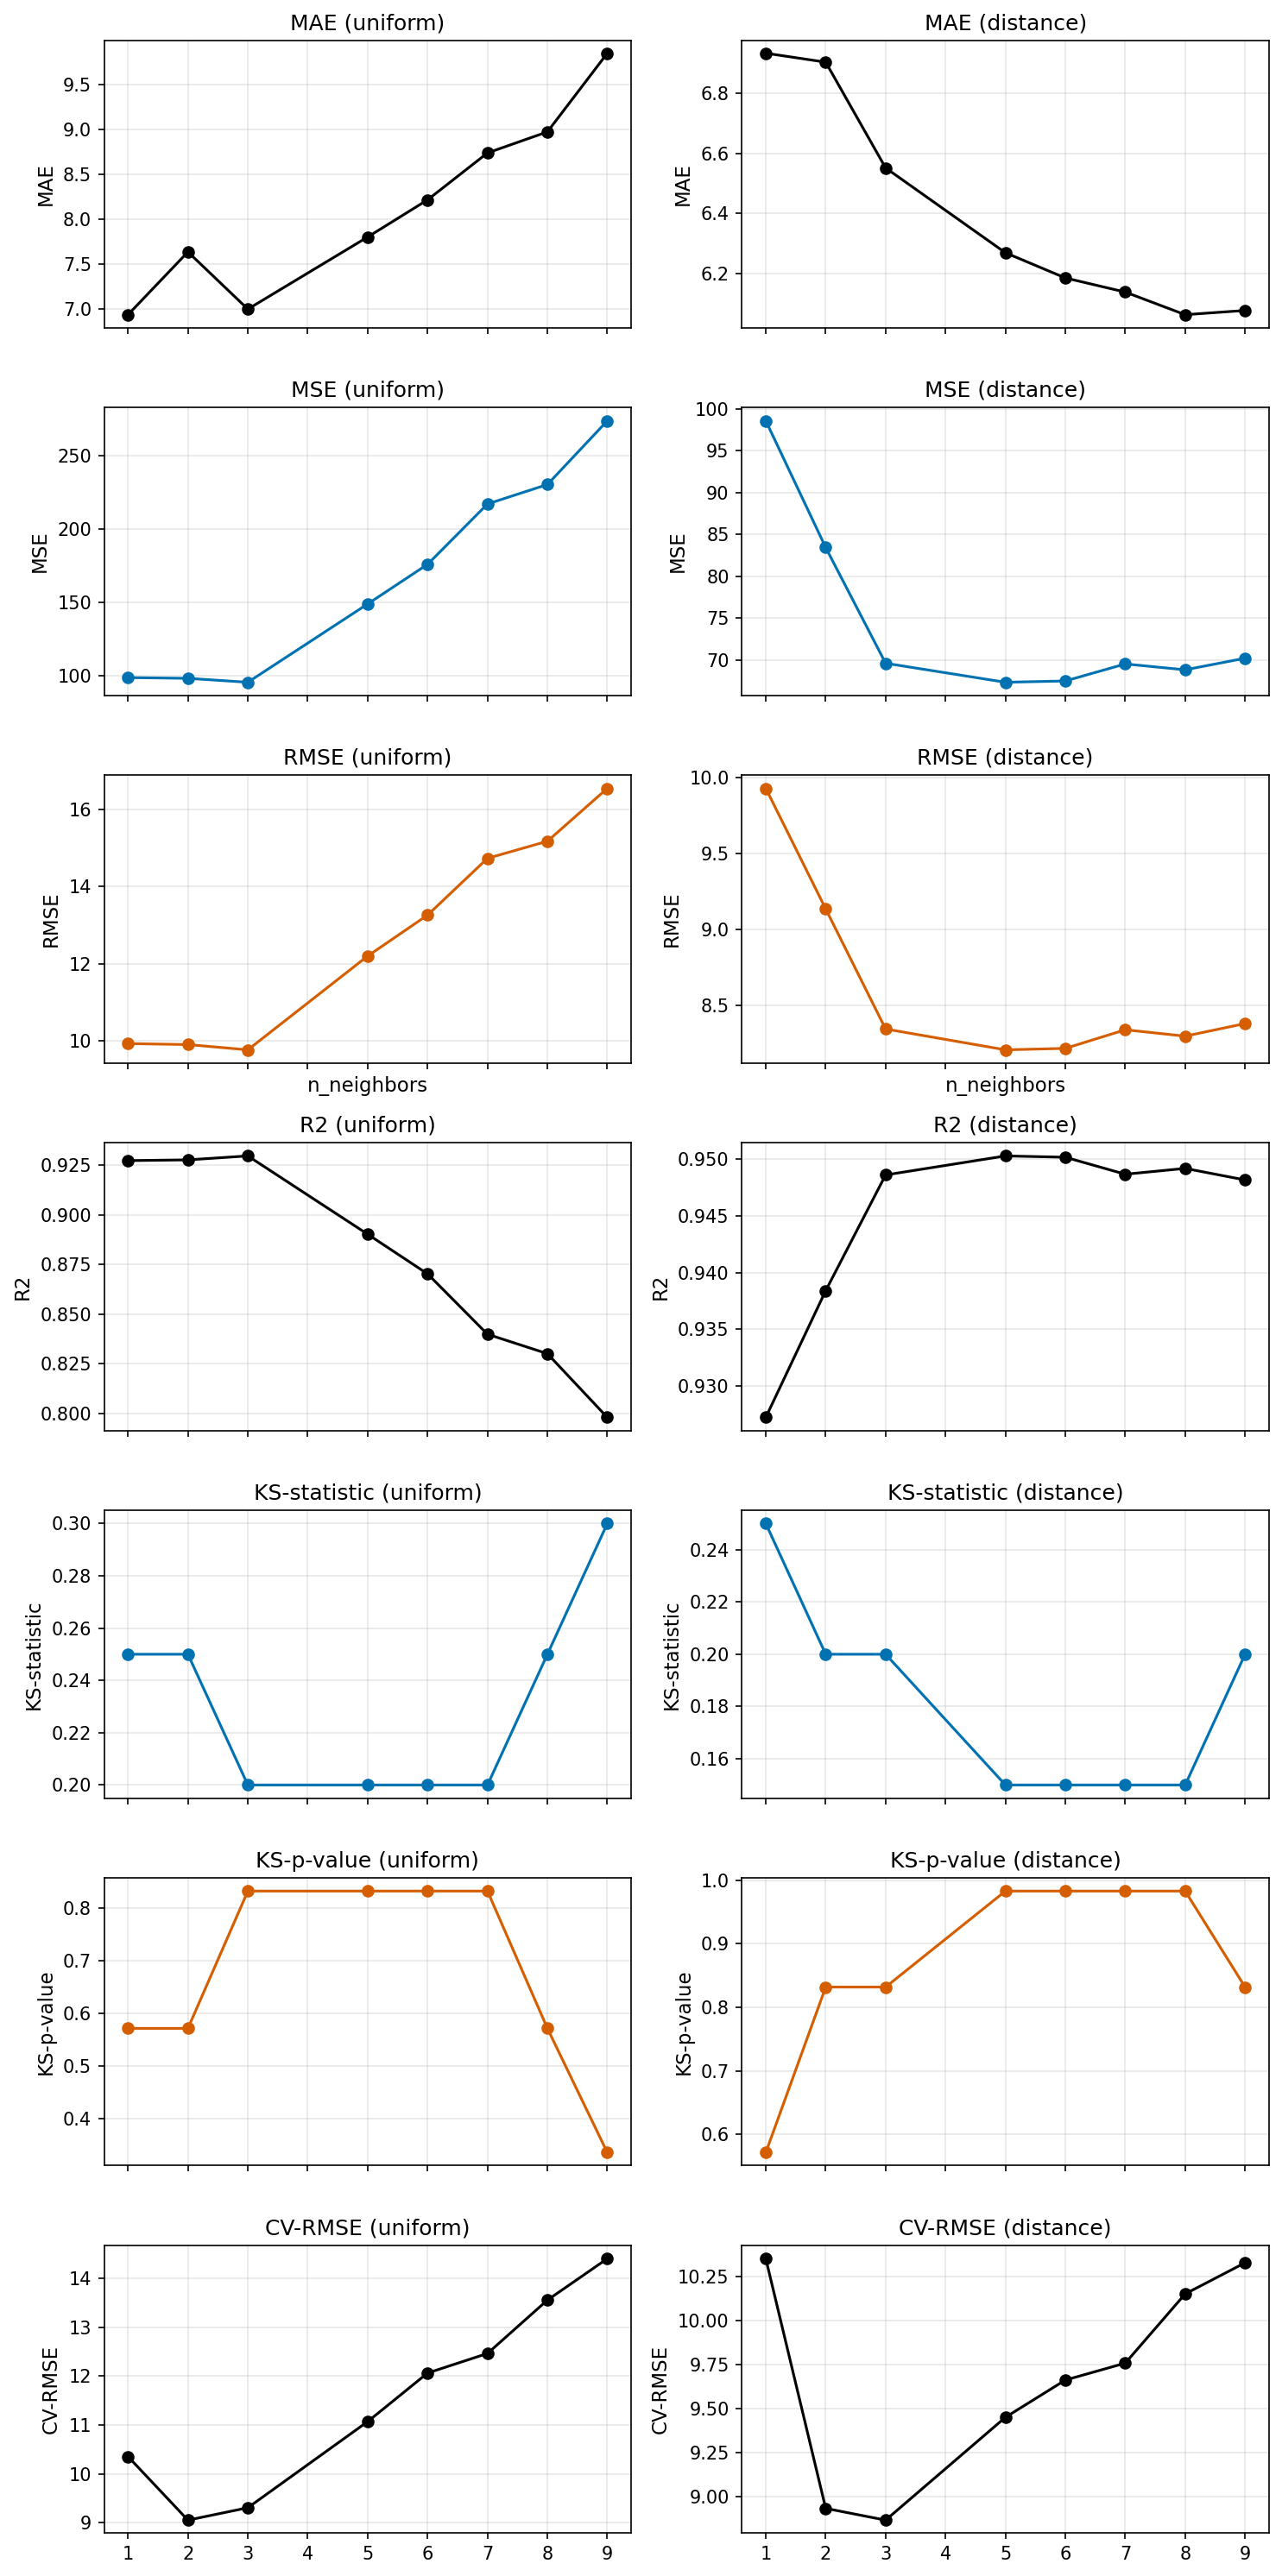

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from scipy.stats import kstest
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.model_selection import train_test_split, cross_val_score
import pickle

poly_df = pd.read_hdf('poly_data.h5')

# Training test split
X, y = poly_df['input'].values, poly_df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, test_size = 0.2, random_state = 1)



# Plot the data

fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.scatter(poly_df['input'],poly_df['target'], color='#D55E00', s = 10)
ax.set_xlabel('X',fontsize = 20)
ax.set_ylabel('y',fontsize = 20)
ax.tick_params(which='both',labelsize = 16)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_title('Polynomial data',fontsize = 24)


list_of_weights = ['uniform','distance']
list_of_neighbors = [1,2,3,5,6,7,8,9]

list_of_hyperparameters = [(n, w) for n in list_of_neighbors for w in list_of_weights]

best_cv = -1000
best_rmse = 1000
best_r2 = 1000

knn_reg_df = pd.DataFrame(columns=['n_neighbors','weights','MAE','MSE','RMSE','R2','KS-statistic','KS-p-value', 'CV-RMSE'])

for n_neighbors, weights in list_of_hyperparameters:

    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ks_result = kstest(y_test, y_pred)


    cv_score = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error') ##check why rmse here
    cv_rmse = -cv_score.mean()

    model_result = pd.DataFrame([[n_neighbors, weights, mae, mse, rmse, r2, ks_result.statistic, ks_result.pvalue, cv_rmse]],
                                columns=['n_neighbors','weights','MAE','MSE','RMSE','R2','KS-statistic','KS-p-value', 'CV-RMSE'])
    
    knn_reg_df = pd.concat([knn_reg_df, model_result], ignore_index=True)


## WORKBOOKS GIVE R2, KS, AND RMSE AS BEST METRICS
    # save model with the highest cross-validation score
    if cv_score.mean() > best_cv:
        best_cv_model = knn
        best_cv = cv_score.mean()
        best_cv_hparam = np.array([neighbors, weights, cv_score.mean(), rmse, r2])
    
    ## CAREFUL WITH BEST < OR >
    if rmse < best_rmse:
        best_rmse_model = knn
        best_rmse = rmse
        best_rmse_hparam = np.array([neighbors, weights, cv_score.mean(), rmse, r2])


    if r2 > best_r2:
        best_auc_model = knn
        best_r2 = r2
        best_r2_hparam = np.array([neighbors, weights, cv_score.mean(), rmse, r2])


display(knn_reg_df)

print(f'Best scores for each metric:')
print(tabulate([best_acc_hparam, best_cv_hparam, best_auc_hparam],
                 headers=['n_neighbors','weights','mean_cv_score','rmse', 'r2'],
                 tablefmt='fancy_grid'))


#Plot best performing model

fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
X_plot = np.linspace(-3,3,1000).reshape(-1,1)
ax.plot(X_plot,best_cv_model.predict(X_plot), color='#D55E00', label = "Best")
ax.scatter(X_train, y_train, color='black',label='Training data', s = 10)
ax.scatter(X_test, y_test, color='#0072B2',label='Test data', s = 10 )
ax.set_xlabel('X',fontsize = 20)
ax.set_ylabel('y',fontsize = 20)
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(4))
ax.tick_params(which='both',labelsize = 12,direction='in',top=True,right=True)
ax.legend(loc='upper center',fontsize = 12, edgecolor='black')






## PERFORMACE METRICS ##
fig, axs = plt.subplots(7, 2, figsize=(10, 20), dpi=150, sharex=True)
metrics = ['MAE','MSE','RMSE','R2','KS-statistic','KS-p-value', 'CV-RMSE']
titles = ['MAE','MSE','RMSE','R2','KS-statistic','KS-p-value', 'CV-RMSE']
colors = ['black', '#0072B2', '#D55E00','black', '#0072B2', '#D55E00', 'black']

for col, weight in enumerate(['uniform', 'distance']):
    subset = knn_reg_df[knn_reg_df['weights'] == weight].sort_values('n_neighbors')
    x = subset['n_neighbors']

    for row, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
        ax = axs[row, col]
        ax.plot(x, subset[metric], marker='o', color=color)
        ax.set_title(f'{title} ({weight})', fontsize=12)
        ax.set_ylabel(title, fontsize=11)
        ax.grid(True, alpha=0.3)
        if row == 2:
            ax.set_xlabel('n_neighbors', fontsize=11)
        ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()



- Generally, kNN not that great for regression problems....

#### Interpretation of KS results

--> smallest D-Value indicates best fit.

--> largest p-value indicates best fit. Reject null hypothesis if p value is less than significance level. For example, p=0.66 --> '66% chance of finding this level of fit or worse (larger D)' , it means that if the sample actually came from the normal distribution, there is a 66% probability that a random sample would have a D-value at least this large (or an even worse fit).

## SVC (NON EXAMINABLE)

### **SVC Classification**

/var/folders/pw/d23366lj4q933d83b9n0xfwm0000gn/T/ipykernel_49773/4089893670.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SVC_df = pd.concat([SVC_df, pd.DataFrame([model_dict])])


,C,kernel,test_accuracy,auc_score,mean_cv_score
0,1.0,linear,0.875,0.947071,0.85500
0,1.0,poly,0.920,0.955943,0.86750
0,1.0,rbf,0.925,0.979534,0.94125
0,1.0,sigmoid,0.645,0.786370,0.61500
0,10.0,linear,0.875,0.946970,0.85500
0,10.0,poly,0.910,0.955439,0.86750
0,10.0,rbf,0.925,0.980038,0.94250
0,10.0,sigmoid,0.640,0.785361,0.61500
0,100.0,linear,0.875,0.946970,0.85375
0,100.0,poly,0.910,0.955237,0.86750


Best scores for each metric:
╒═════╤══════════╤═════════════════╤═════════════╤═════════════════╕
│   C │ kernel   │   test_accuracy │   auc_score │   mean_cv_score │
╞═════╪══════════╪═════════════════╪═════════════╪═════════════════╡
│   1 │ rbf      │           0.925 │    0.979534 │         0.94125 │
├─────┼──────────┼─────────────────┼─────────────┼─────────────────┤
│ 100 │ rbf      │           0.925 │    0.972679 │         0.9475  │
├─────┼──────────┼─────────────────┼─────────────┼─────────────────┤
│  10 │ rbf      │           0.925 │    0.980038 │         0.9425  │
╘═════╧══════════╧═════════════════╧═════════════╧═════════════════╛


Text(0.5, 1.0, 'TITLE')

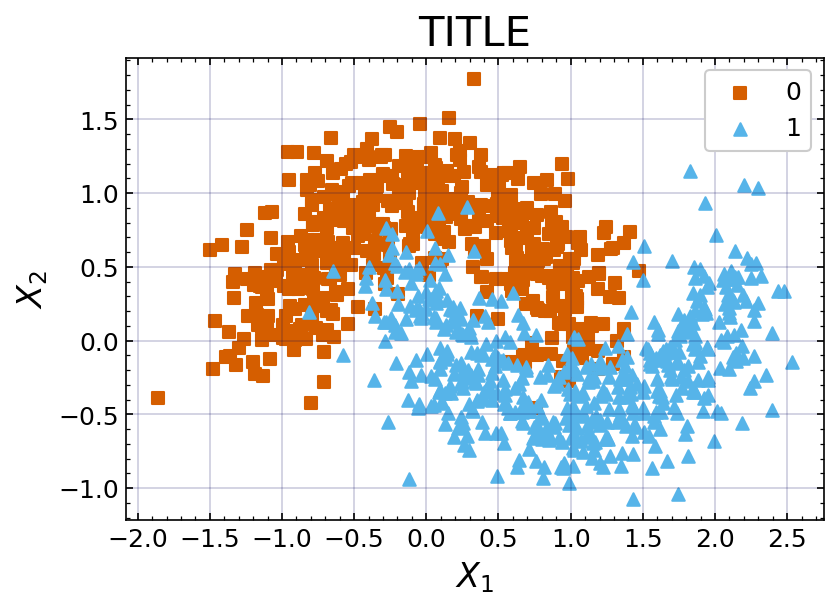

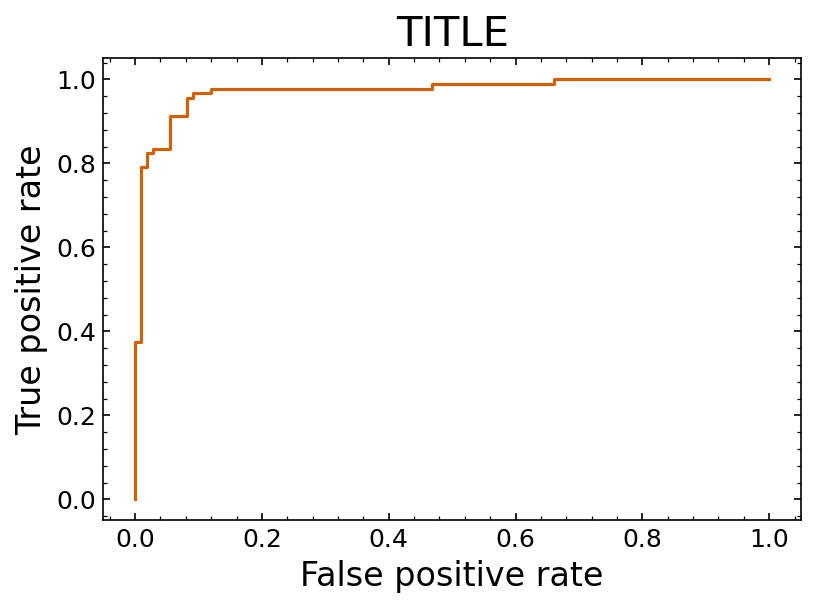

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle

with open("PHYS60022_2m_n1000_r0250_s024.npy", 'rb') as ifp:
    coord = np.load(ifp)
    label = np.load(ifp)


# code to plot the data points
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.scatter(coord[:,0][label==0],coord[:,1][label==0],color='#D55E00',marker='s',label= '0',zorder = 1)
ax.scatter(coord[:,0][label==1],coord[:,1][label==1],color='#56B4E9',marker='^',label='1',zorder = 1)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',labelsize= 12,direction='in',top=True,right=True)
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend(loc='upper right',fontsize = 12,framealpha = 1)
ax.set_title('TITLE',fontsize = 20)



#import libraries needed
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.metrics import roc_curve
from tabulate import tabulate




list_of_C = [1.0, 10.0, 100.0]
list_of_kernels = ['linear','poly','rbf','sigmoid']

list_of_hyperparameters = [(C, k) for C in list_of_C for k in list_of_kernels]


SVC_df = pd.DataFrame(columns=['C','kernel','test_accuracy', 'auc_score','mean_cv_score'])

# Split data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(coord, label, test_size = 0.2,random_state = 3) 



best_cv = 0
best_acc = 0
best_auc = 0


#looping through parameters
for C, kernel in list_of_hyperparameters:
    model = SVC(C = C, kernel = kernel, probability=True)
    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)
    cv_score = cross_val_score(model, X_train, y_train)
    acc = accuracy_score(y_test, y_pred)

    y_score = model.predict_proba(X_test)[:,1] #calculate scores of test data
    auc_score = roc_auc_score(y_test, y_score)

    #add hyperparameters and scores to data frame
    model_dict = {'C':C, 'kernel':kernel,'test_accuracy':acc,'auc_score':auc_score,'mean_cv_score':cv_score.mean()}
    SVC_df = pd.concat([SVC_df, pd.DataFrame([model_dict])])



    # save model with the highest cross-validation score
    if cv_score.mean() > best_cv:
        best_cv_model = model
        best_cv = cv_score.mean()
        best_cv_hparam = np.array([C, kernel, acc, auc_score, cv_score.mean()])
    
    # save model with the highest accuracy
    if acc > best_acc:
        best_acc_model = model
        best_acc = acc
        best_acc_hparam = np.array([C, kernel, acc, auc_score, cv_score.mean()])

    # save model with the highest auc
    if auc_score > best_auc:
        best_auc_model = model
        best_auc = auc_score
        best_auc_hparam = np.array([C, kernel, acc, auc_score, cv_score.mean()])


display(SVC_df)

print(f'Best scores for each metric:')
print(tabulate([best_acc_hparam, best_cv_hparam, best_auc_hparam],
                 headers=['C','kernel','test_accuracy','auc_score', 'mean_cv_score'],
                 tablefmt='fancy_grid'))



## ROC CURVE PLOTTING ##

y_pred = best_cv_model.predict(X_test)
y_score = best_cv_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.plot(fpr, tpr, color='#D55E00')
ax.set_xlabel('False positive rate',fontsize = 16)
ax.set_ylabel('True positive rate',fontsize = 16)
ax.xaxis.set_minor_locator(MultipleLocator(0.04))
ax.yaxis.set_minor_locator(MultipleLocator(0.04))
ax.tick_params(which='both',labelsize = 12, direction='in',top=True,right=True)
ax.set_title('TITLE',fontsize = 20)


### <b>SVC Regression<b>

/var/folders/pw/d23366lj4q933d83b9n0xfwm0000gn/T/ipykernel_49773/2186437051.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SVR_reg_df = pd.concat([SVR_reg_df, model_result], ignore_index=True)


,C,episilon,gamma,MAE,MSE,RMSE,R2,KS-statistic,KS-p-value,CV-RMSE,epsilon
0,10,NaN,0.25,21.023748,1031.274599,32.113464,0.238715,0.35,0.174533,10.32939,0.2
1,10,NaN,0.50,17.207884,716.667091,26.770639,0.470958,0.30,0.335591,10.32939,0.2
2,10,NaN,1.00,16.083837,573.408358,23.945947,0.576711,0.30,0.335591,10.32939,0.2
3,10,NaN,2.00,13.502101,390.765554,19.767791,0.711538,0.30,0.335591,10.32939,0.2
4,10,NaN,4.00,11.539152,306.970257,17.520567,0.773395,0.30,0.335591,10.32939,0.2
5,10,NaN,0.25,21.181922,1044.948245,32.325659,0.228621,0.35,0.174533,10.32939,0.6
6,10,NaN,0.50,17.224899,715.744308,26.753398,0.471639,0.30,0.335591,10.32939,0.6
7,10,NaN,1.00,16.049292,569.394286,23.861984,0.579674,0.30,0.335591,10.32939,0.6
8,10,NaN,2.00,13.552800,393.879851,19.846407,0.709239,0.30,0.335591,10.32939,0.6
9,10,NaN,4.00,11.627084,313.443358,17.704332,0.768617,0.30,0.335591,10.32939,0.6


Best scores for each metric:
╒═══════════════╤═══════════╤═════════════════╤═══════════╤══════════╕
│   n_neighbors │ weights   │   mean_cv_score │      rmse │       r2 │
╞═══════════════╪═══════════╪═════════════════╪═══════════╪══════════╡
│             1 │ rbf       │          0.925  │  0.979534 │ 0.94125  │
├───────────────┼───────────┼─────────────────┼───────────┼──────────┤
│            95 │ distance  │        -10.3294 │ 32.1135   │ 0.238715 │
├───────────────┼───────────┼─────────────────┼───────────┼──────────┤
│            10 │ rbf       │          0.925  │  0.980038 │ 0.9425   │
╘═══════════════╧═══════════╧═════════════════╧═══════════╧══════════╛


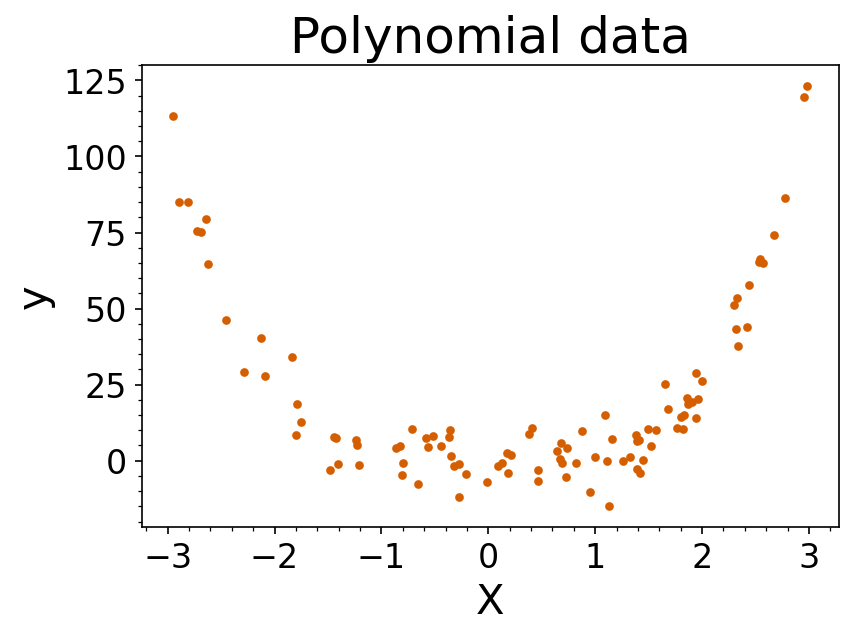

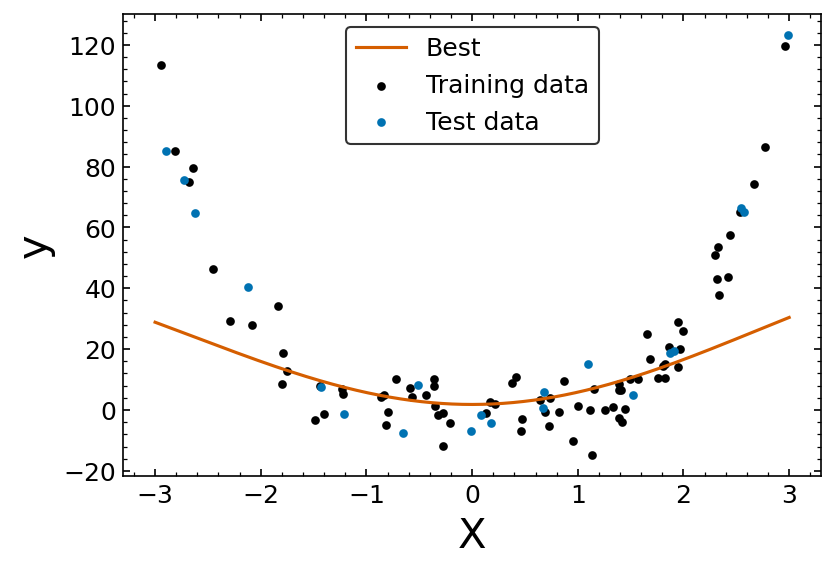

In [35]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from scipy.stats import kstest
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.model_selection import train_test_split, cross_val_score
import pickle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR

poly_df = pd.read_hdf('poly_data.h5')

# Training test split
X, y = poly_df['input'].values, poly_df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, test_size = 0.2, random_state = 1)



# Plot the data

fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.scatter(poly_df['input'],poly_df['target'], color='#D55E00', s = 10)
ax.set_xlabel('X',fontsize = 20)
ax.set_ylabel('y',fontsize = 20)
ax.tick_params(which='both',labelsize = 16)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_title('Polynomial data',fontsize = 24)


list_of_C = [10, 1000]
list_of_eps = [0.2,0.6] # Small values because we are using RobustScaler
list_of_gamma = [0.25,0.5,1.0,2.0,4.0]

list_of_hparams = [(C,e,g) for C in list_of_C for e in list_of_eps for g in list_of_gamma]

best_cv = -1000
best_rmse = 1000
best_r2 = 1000

SVR_reg_df = pd.DataFrame(columns=['C','episilon','gamma', 'MAE','MSE','RMSE','R2','KS-statistic','KS-p-value', 'CV-RMSE'])

for C, epsilon, gamma in list_of_hparams:
    # Define the model
    svr_model = make_pipeline(RobustScaler(),
                              SVR(kernel='rbf',epsilon = epsilon, C = C, gamma = gamma))
    svr_model.fit(X_train, y_train)
    y_pred = svr_model.predict(X_test)


    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ks_result = kstest(y_test, y_pred)
    cv_score = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error') ##check why rmse here
    cv_rmse = -cv_score.mean()

    model_result = pd.DataFrame([[C, epsilon, gamma, mae, mse, rmse, r2, ks_result.statistic, ks_result.pvalue, cv_rmse]],
                                columns=['C','epsilon','gamma', 'MAE','MSE','RMSE','R2','KS-statistic','KS-p-value', 'CV-RMSE'])
    
    SVR_reg_df = pd.concat([SVR_reg_df, model_result], ignore_index=True)


## WORKBOOKS GIVE R2, KS, AND RMSE AS BEST METRICS
    # save model with the highest cross-validation score
    if cv_score.mean() > best_cv:
        best_cv_model = svr_model
        best_cv = cv_score.mean()
        best_cv_hparam = np.array([neighbors, weights, cv_score.mean(), rmse, r2])
    
    ## CAREFUL WITH BEST < OR >
    if rmse < best_rmse:
        best_rmse_model = svr_model
        best_rmse = rmse
        best_rmse_hparam = np.array([neighbors, weights, cv_score.mean(), rmse, r2])


    if r2 > best_r2:
        best_auc_model = svr_model
        best_r2 = r2
        best_r2_hparam = np.array([neighbors, weights, cv_score.mean(), rmse, r2])


display(SVR_reg_df)

print(f'Best scores for each metric:')
print(tabulate([best_acc_hparam, best_cv_hparam, best_auc_hparam],
                 headers=['n_neighbors','weights','mean_cv_score','rmse', 'r2'],
                 tablefmt='fancy_grid'))


#Plot best performing model

fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
X_plot = np.linspace(-3,3,1000).reshape(-1,1)
ax.plot(X_plot,best_cv_model.predict(X_plot), color='#D55E00', label = "Best")
ax.scatter(X_train, y_train, color='black',label='Training data', s = 10)
ax.scatter(X_test, y_test, color='#0072B2',label='Test data', s = 10 )
ax.set_xlabel('X',fontsize = 20)
ax.set_ylabel('y',fontsize = 20)
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(4))
ax.tick_params(which='both',labelsize = 12,direction='in',top=True,right=True)
ax.legend(loc='upper center',fontsize = 12, edgecolor='black')




# Week 6: Performance Metrics

In [ ]:
# Classification metics
from sklearn.metrics import auc, roc_auc_score, accuracy_score, roc_curve, log_loss

# Regression metics
from sklearn.metrics import mean_squared_error, r2_score

# Week 7: Decision Trees

Definitions and general:

* The tree is made of **nodes** and **branches**; at each node, we examine one of our features and compare it to some threshold value 
<br>
* Root node - the first node 
<br>
* Leaf nodes (the final node) - which has no branches - are where we make a prediction: either a class label, for a classification problem, or a target value, for a regression problem.
<br>
* Hyperparameters: maximum tree depth, minimum samples to split an internal node, minimum samples required at a leaf node, etc

Advantages:

Disadvantages:
* Complex decision boundary / prone to overfitting - 'greedy' nature of the algorithm means it's highly optimised to the training data.
* Can perform badly on unseen data


DECISION TREES FOR CLASSIFICATION:
* When we train a decision tree for classification, we want to minimise the number of nodes to make sure evaluation is as fast as possible.

Basic example

DECISION TREES FOR REGRESSION:

LOSS FUNCTIONS: probability of incorrectly labelling a sample

<br>
Classification performance metrics:
<br>

* Gini Impurity 
\begin{equation*}
G_i = 1 - \sum_k p_{i, k}^2,
\end{equation*}
where $G_i$ is the Gini impurity of node $i$ and $p_{i, k}$ is the probability of selecting a sample with class $k$ if we select a random sample at node $i$. 
<br>

* Log loss / entropy
\begin{equation*}
H_i = -\sum_k p_{i, k}\log_2\left(p_{i,k}\right)
\end{equation*}

Aim is to minimise the loss function for each node.
<br>

Regression performance metrics: `sklearn.metrics` > `mean_squared_error`, `r2_score`
<br>

* Mean squared error:

\begin{align*}
\bar{y}_m &= \frac{1}{n_m}\sum_{y\,\in\,Q_m}y \\
H(Q_m) &= \frac{1}{n_m}\sum_{y\,\in\,Q_m}(y - \bar{y}_m)^2
\end{align*}

$\bar{y}_m$ is the mean of all the values of $y$ in the set $Q_m$, which is the set of training data at node $m$. 

* Half Poisson deviance (best used for targets that are counts or frequencies, requries $y \geq 0$)

\begin{equation*}
H(Q_m) = \frac{1}{n_m}\sum_{y\,\in\,Q_m}\left(y\log\frac{y}{\hat{y}_m} - y + \hat{y}_m\right)
\end{equation*}

* Mean absolute error:

\begin{align*}
\text{median}(y)_m = \underset{y\,\in\,Q_m}{\text{median}}(y)& \\
H(Q_m) = \frac{1}{n_m}\sum_{y\,\in\,Q_m}|y - \text{median}(y)_m|&
\end{align*}

Note: for the mean absolute error, the prediction is the median of the dataset $Q_m$, instead of the mean. 


ENSEMBLE LEARNING AND RANDOM FORESTS:

Use many individual models (which may be the same type of model or different ones, e.g. a mixture of SVMs and DTs), which make their own independent predictions, and we use some voting scheme to determine the ensemble prediction based on the individual predictions of each model:

* For classification, we can use either: 
    * Hard voting: the prediction is the most common prediction across all the models
    * Soft voting: the prediction is the most probable prediction across all the models i.e. predicts the class with the greatest total probability across all models in the ensemble
<br>
* For regression, we can predict either the mean prediction across all models in the ensemble, or a weighted mean. This lets us assign different weights to different models.

Random forest - ensemble consisting only of decision trees (training data must be varied):

* Bagging: short for "bootstrap aggregation", refers to taking samples from the training dataset *with replacement*. Each sample in the complete training dataset can be selected more than once for a given individual model training dataset.
<br>

* Pasting: rather than replacing training samples after they have been selected, samples are drawn from the complete dataset *without replacement*. Each sample in the complete training dataset can only be selected once for a given individual model training dataset.


Hyperparameters: 
* Basic decision tree parameters (e.g. `max_depth`, `min_samples_split` and `min_samples_leaf`)
* `n_estimators`: the number of different estimators (in this case, decision trees) to train to form the ensemble
<br>

* `max_samples`: the number of samples to use from the training data set for each estimator
<br>

* `bootstrap`: whether to draw with replacement or not. `bootstrap = True` means sampling with replacement.
<br>

* `n_jobs`: number of CPU cores to use during training & prediction. Important when we have lots of estimators/data to speed things up.
<br>

* `oob_score`: whether to calculate the OOB (out of bag) score to test the generalisation of the model

Ensemble basic example:

Random Forest Classifier Example:

BOOSTED DECISION TREES

A random forest consisting of weak learners (shallow trees) that combine to make a strong learner
<br>
* **Weak learner**: a classifier that is only slightly correlated with the true classification, i.e. performs slightly better than randomly assigning classes
<br>
* **Strong learner**: a classifier that is arbitrarily well-correlated with the true classification, i.e. correctly predicts classes the vast majority of the time

Examples:
* Adaptive boosting (AdaBoost): `sklearn.ensemble` as `AdaBoostClassifier` / `AdaBoostRegressor`
* Gradient boosting: `sklearn.ensemble` as `GradientBoostingClassifier` / `GradientBoostingRegressor`
* Extreme gradient boost (XGBoost): `xgboost` as `XGBClassifier` / `XGBRegressor`

XGBoost example:

### <b>Classification<b>



<b>Basic Decision Tree<b>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn import tree
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from matplotlib.colors import ListedColormap


with open("PHYS60022_2m_n1000_r0250_s024.npy", 'rb') as ifp:
    coord = np.load(ifp)
    label = np.load(ifp)


# code to plot the data points
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.scatter(coord[:,0][label==0],coord[:,1][label==0],color='#D55E00',marker='s',label= '0',zorder = 1)
ax.scatter(coord[:,0][label==1],coord[:,1][label==1],color='#56B4E9',marker='^',label='1',zorder = 1)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',labelsize= 12,direction='in',top=True,right=True)
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend(loc='upper right',fontsize = 12,framealpha = 1)
ax.set_title('TITLE',fontsize = 20)


X_train, X_test, y_train, y_test = train_test_split(coord, label, test_size = 0.2,random_state = 3) 




list_of_depth = [2, 3, 4, 5, 10, 20, 100, None]
list_of_min_split = [2, 3, 4, 5, 10]
list_of_min_samples = [1, 2, 5]

list_of_hparams = [(d, sp, sa) for d in list_of_depth for sp in list_of_min_split for sa in list_of_min_samples]

results_df = pd.DataFrame(columns=['max_depth','min_samples_split','min_samples_leaf','accuracy', 'cv_score', 'auc_score'])




best_cv = 0
for max_depth, min_samples_split, min_samples_leaf in list_of_hparams:
    # Note: fix random state as decision trees shuffle data, and the order in which data is shown matters
    clf = tree.DecisionTreeClassifier(max_depth = max_depth,
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                  random_state = 1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    cv_score = cross_val_score(clf, X_train, y_train)

    y_score = clf.predict_proba(X_test)[:,1] #calculate scores of test data
    auc_score = roc_auc_score(y_test, y_score)


    if cv_score.mean() > best_cv:
        best_cv = cv_score.mean()
        with open('best_iris_dt.pkl','wb') as f:
            pickle.dump(clf, f)

    model_df = pd.DataFrame(np.array([[max_depth, min_samples_split, min_samples_leaf, acc, cv_score.mean(), auc_score]]),
                            columns = results_df.columns)

    results_df = pd.concat([results_df, model_df])



display(results_df)


## BEST MODEL ##
with open('best_iris_dt.pkl','rb') as f:
    best_model = pickle.load(f)


acc = accuracy_score(y_test, clf.predict(X_test))
roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

print('Classification accuracy = {:.1f}%'.format(acc*100))
print('ROC-AUC score = {:.5f}'.format(roc))

## Plot ROC-AUC curve ##

fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

fig, ax = plt.subplots(1,1,figsize = (6, 4), dpi = 150)
ax.plot(fpr, tpr, color='#D55E00')
ax.set_xlabel('False positive rate',fontsize = 20)
ax.set_ylabel('True positive rate',fontsize = 20)
ax.set_title('ROC curve, best simple model',fontsize = 24)
ax.xaxis.set_minor_locator(MultipleLocator(0.04))
ax.yaxis.set_minor_locator(MultipleLocator(0.04))
ax.tick_params(which='both',direction='in',top=True,right=True,labelsize = 16)
ax.grid(color='xkcd:dark blue',alpha = 0.2)




## FANCY DECISION BOUNDARY PLOT ##
x1s, x2s = np.linspace(-2,2.7,100), np.linspace(-1.5,1.8,100)
x1, x2 = np.meshgrid(x1s, x2s)
X_new = np.c_[x1.ravel(), x2.ravel()]
y_pred = clf.predict(X_new).reshape(x1.shape)
custom_cmap = ListedColormap(['#D55E00','black','#56B4E9'])


fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.contourf(x1,x2,y_pred,alpha = 0.2, cmap = custom_cmap,zorder = 0)
ax.contour(x1,x2,y_pred,cmap = custom_cmap,zorder = 0, alpha = 0.5)
ax.scatter(X_test[:,0][y_test==0],X_test[:,1][y_test==0],color='#D55E00',marker='s',label= 'Class 1',zorder = 1,edgecolor='black',lw = 0.5)
ax.scatter(X_test[:,0][y_test==1],X_test[:,1][y_test==1],color='#56B4E9',marker='^',label='Class 2',zorder = 1,edgecolor='black',lw = 0.5)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',labelsize= 12,direction='in',top=True,right=True)
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend(loc='upper right',fontsize = 12, framealpha = 1)
ax.set_title('Test data, best simple decision tree',fontsize = 20)






## NO HYPERPARAMETER TUNING VISUALISATION ##











<b> Random Forest <b>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn import tree
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier



with open("PHYS60022_2m_n1000_r0250_s024.npy", 'rb') as ifp:
    coord = np.load(ifp)
    label = np.load(ifp)


# code to plot the data points
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.scatter(coord[:,0][label==0],coord[:,1][label==0],color='#D55E00',marker='s',label= '0',zorder = 1)
ax.scatter(coord[:,0][label==1],coord[:,1][label==1],color='#56B4E9',marker='^',label='1',zorder = 1)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',labelsize= 12,direction='in',top=True,right=True)
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend(loc='upper right',fontsize = 12,framealpha = 1)
ax.set_title('TITLE',fontsize = 20)


X_train, X_test, y_train, y_test = train_test_split(coord, label, test_size = 0.2,random_state = 3) 




list_of_depth = [2, 3, 4]
list_of_n_estimators = [50, 100]
list_of_min_split = [2, 5]
list_of_min_leaf = [1]

list_of_hparams = [(d,n,s,l) for d in list_of_depth 
                              for n in list_of_n_estimators 
                              for s in list_of_min_split 
                              for l in list_of_min_leaf]



results_df = pd.DataFrame(columns=['max_depth','min_samples_split','min_samples_leaf', 'n_estimators', 'accuracy', 'cv_score', 'auc_score', 'oob_score'])




best_cv = 0
for max_depth, n_estimators, min_samples_split, min_samples_leaf in list_of_hparams:
    clf = RandomForestClassifier(max_depth = max_depth,
                                 n_estimators = n_estimators,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 oob_score=True,
                                 random_state = 1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    cv_score = cross_val_score(clf, X_train, y_train)

    y_score = clf.predict_proba(X_test)[:,1] #calculate scores of test data
    auc_score = roc_auc_score(y_test, y_score)


    if cv_score.mean() > best_cv:
        best_cv = cv_score.mean()
        with open('best_iris_dt.pkl','wb') as f:
            pickle.dump(clf, f)

    model_df = pd.DataFrame(np.array([[max_depth, min_samples_split, min_samples_leaf, n_estimators, acc, cv_score.mean(), auc_score, clf.oob_score_]]),
                            columns = results_df.columns)

    results_df = pd.concat([results_df, model_df])



display(results_df)


## BEST MODEL ##
with open('best_iris_dt.pkl','rb') as f:
    best_model = pickle.load(f)


acc = accuracy_score(y_test, clf.predict(X_test))
roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

print('Classification accuracy = {:.1f}%'.format(acc*100))
print('ROC-AUC score = {:.5f}'.format(roc))

## Plot ROC-AUC curve ##

fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

fig, ax = plt.subplots(1,1,figsize = (6, 4), dpi = 150)
ax.plot(fpr, tpr, color='#D55E00')
ax.set_xlabel('False positive rate',fontsize = 20)
ax.set_ylabel('True positive rate',fontsize = 20)
ax.set_title('ROC curve, best simple model',fontsize = 24)
ax.xaxis.set_minor_locator(MultipleLocator(0.04))
ax.yaxis.set_minor_locator(MultipleLocator(0.04))
ax.tick_params(which='both',direction='in',top=True,right=True,labelsize = 16)
ax.grid(color='xkcd:dark blue',alpha = 0.2)




## FANCY DECISION BOUNDARY PLOT ##
x1s, x2s = np.linspace(-2,2.7,100), np.linspace(-1.5,1.8,100)
x1, x2 = np.meshgrid(x1s, x2s)
X_new = np.c_[x1.ravel(), x2.ravel()]
y_pred = clf.predict(X_new).reshape(x1.shape)
custom_cmap = ListedColormap(['#D55E00','black','#56B4E9'])


fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.contourf(x1,x2,y_pred,alpha = 0.2, cmap = custom_cmap,zorder = 0)
ax.contour(x1,x2,y_pred,cmap = custom_cmap,zorder = 0, alpha = 0.5)
ax.scatter(X_test[:,0][y_test==0],X_test[:,1][y_test==0],color='#D55E00',marker='s',label= 'Class 1',zorder = 1,edgecolor='black',lw = 0.5)
ax.scatter(X_test[:,0][y_test==1],X_test[:,1][y_test==1],color='#56B4E9',marker='^',label='Class 2',zorder = 1,edgecolor='black',lw = 0.5)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',labelsize= 12,direction='in',top=True,right=True)
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend(loc='upper right',fontsize = 12, framealpha = 1)
ax.set_title('Test data, best random forest decision tree',fontsize = 20)






## NO HYPERPARAMETER TUNING VISUALISATION ##











<b>XGBoost<b>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn import tree
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb




with open("PHYS60022_2m_n1000_r0250_s024.npy", 'rb') as ifp:
    coord = np.load(ifp)
    label = np.load(ifp)


# code to plot the data points
fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.scatter(coord[:,0][label==0],coord[:,1][label==0],color='#D55E00',marker='s',label= '0',zorder = 1)
ax.scatter(coord[:,0][label==1],coord[:,1][label==1],color='#56B4E9',marker='^',label='1',zorder = 1)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',labelsize= 12,direction='in',top=True,right=True)
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend(loc='upper right',fontsize = 12,framealpha = 1)
ax.set_title('TITLE',fontsize = 20)


X_train, X_test, y_train, y_test = train_test_split(coord, label, test_size = 0.2,random_state = 3) 




list_of_max_depth = [2, 10, None]
list_of_max_leaves = [10, 50, None]
list_of_learning_rate = [0.01]
list_of_n_estimators = [5, 50]

list_of_hparams = [(d, l, lr, n) for d in list_of_max_depth 
                                 for l in list_of_max_leaves 
                                 for lr in list_of_learning_rate 
                                 for n in list_of_n_estimators]



results_df = pd.DataFrame(columns=['max_depth','max_leaves','learning_rate', 'n_estimators', 'accuracy', 'cv_score', 'auc_score'])




best_cv = 0
for max_depth, max_leaves, learning_rate, n_estimators in list_of_hparams:
    clf = XGBClassifier(max_depth = max_depth, 
                        max_leaves = max_leaves, 
                        learning_rate = learning_rate, 
                        n_estimators = n_estimators,
                        random_state = 1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    cv_score = cross_val_score(clf, X_train, y_train)

    y_score = clf.predict_proba(X_test)[:,1] #calculate scores of test data
    auc_score = roc_auc_score(y_test, y_score)


    if cv_score.mean() > best_cv:
        best_cv = cv_score.mean()
        with open('best_iris_dt.pkl','wb') as f:
            pickle.dump(clf, f)

    model_df = pd.DataFrame(np.array([[max_depth, max_leaves, learning_rate, n_estimators, acc, cv_score.mean(), auc_score]]),
                            columns = results_df.columns)

    results_df = pd.concat([results_df, model_df])



display(results_df)


## BEST MODEL ##
with open('best_iris_dt.pkl','rb') as f:
    best_model = pickle.load(f)


acc = accuracy_score(y_test, clf.predict(X_test))
roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

print('Classification accuracy = {:.1f}%'.format(acc*100))
print('ROC-AUC score = {:.5f}'.format(roc))

## Plot ROC-AUC curve ##

fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

fig, ax = plt.subplots(1,1,figsize = (6, 4), dpi = 150)
ax.plot(fpr, tpr, color='#D55E00')
ax.set_xlabel('False positive rate',fontsize = 20)
ax.set_ylabel('True positive rate',fontsize = 20)
ax.set_title('ROC curve, best simple model',fontsize = 24)
ax.xaxis.set_minor_locator(MultipleLocator(0.04))
ax.yaxis.set_minor_locator(MultipleLocator(0.04))
ax.tick_params(which='both',direction='in',top=True,right=True,labelsize = 16)
ax.grid(color='xkcd:dark blue',alpha = 0.2)




## FANCY DECISION BOUNDARY PLOT ##
x1s, x2s = np.linspace(-2,2.7,100), np.linspace(-1.5,1.8,100)
x1, x2 = np.meshgrid(x1s, x2s)
X_new = np.c_[x1.ravel(), x2.ravel()]
y_pred = clf.predict(X_new).reshape(x1.shape)
custom_cmap = ListedColormap(['#D55E00','black','#56B4E9'])


fig, ax = plt.subplots(1,1,figsize = (6,4),dpi = 150)
ax.contourf(x1,x2,y_pred,alpha = 0.2, cmap = custom_cmap,zorder = 0)
ax.contour(x1,x2,y_pred,cmap = custom_cmap,zorder = 0, alpha = 0.5)
ax.scatter(X_test[:,0][y_test==0],X_test[:,1][y_test==0],color='#D55E00',marker='s',label= 'Class 1',zorder = 1,edgecolor='black',lw = 0.5)
ax.scatter(X_test[:,0][y_test==1],X_test[:,1][y_test==1],color='#56B4E9',marker='^',label='Class 2',zorder = 1,edgecolor='black',lw = 0.5)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',labelsize= 12,direction='in',top=True,right=True)
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend(loc='upper right',fontsize = 12, framealpha = 1)
ax.set_title('Test data, XGBoost decision tree',fontsize = 20)






## NO HYPERPARAMETER TUNING VISUALISATION ##











### <b>Regression<b>


<b>Simple Decision Tree<b>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn import tree
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from scipy.stats import kstest
from scipy.stats import ks_2samp




np.random.seed(42) # Set the seed for consistency

X = 6*np.random.rand(1000,1) - 3
y = 0.5*X**2 + X + 2 + np.random.randn(1000,1)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 1)



list_of_depth = [2,5]
list_of_min_split = [2, 5]
list_of_min_leaf = [1, 2]

list_of_hparams = [(d,sp,sa) for d in list_of_depth for sp in list_of_min_split for sa in list_of_min_leaf]

best_rmse = 10000
best_r2 = -1000

results_df = pd.DataFrame(columns=['method','max_depth','min_samples_split','min_samples_leaf','MAE','MSE','RMSE','R2','KS-statistic','KS-p-value', 'CV-RMSE'])

for max_depth, min_samples_split, min_samples_leaf in list_of_hparams:
    reg = tree.DecisionTreeRegressor(max_depth = max_depth, 
                                     min_samples_split = min_samples_split, 
                                     min_samples_leaf = min_samples_leaf,
                                     random_state = 1)    
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ks_result = ks_2samp(y_test.flatten(), y_pred.flatten()) #careful with this, ks_2samp is not the same as kstest (which is used in examples)


    cv_score = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error') ##check why rmse here
    cv_rmse = -cv_score.mean()


    if r2 > best_r2:
        best_r2 = r2
        with open('best_reg_dt.pkl','wb') as f:
            pickle.dump(reg, f)
    elif r2 ==best_r2 and rmse < best_rmse:
        best_rmse = rmse
        with open('best_reg_dt.pkl','wb') as f:
            pickle.dump(reg, f)
        

    model_df = pd.DataFrame(
    [[
        'Decision tree',
        max_depth,
        min_samples_split,
        min_samples_leaf,
        mae,
        mse,
        rmse,
        r2,
        ks_result.statistic,
        ks_result.pvalue,
        cv_rmse
    ]],
    columns=[
        'method',
        'max_depth',
        'min_samples_split',
        'min_samples_leaf',
        'MAE',
        'MSE',
        'RMSE',
        'R2',
        'KS-statistic',
        'KS-p-value',
        'CV-RMSE'
    ]
)
    
    results_df = pd.concat([results_df,model_df])



display(results_df)



with open('best_reg_dt.pkl','rb') as f:
    reg = pickle.load(f)
    
xs = np.linspace(-3,3,1000)

fig, ax = plt.subplots(1,1,figsize = (8,24/5),dpi = 150)
ax.scatter(X,y,color='#D55E00',s = 3, label = 'Data')

ys = reg.predict(xs.reshape(-1,1))
ax.plot(xs, ys, color='black',label='Decision tree prediction')

ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$y$',fontsize = 16)
ax.set_xlim(-3,3)
ax.set_ylim(0,10)
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.4))
ax.tick_params(direction='in',top=True,right=True,labelsize = 12,which='both')
ax.legend(loc='upper left',fontsize = 12)


<b> Random Forest <b>

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn import tree
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from scipy.stats import kstest
from scipy.stats import ks_2samp




np.random.seed(42) # Set the seed for consistency

X = 6*np.random.rand(1000,1) - 3
y = 0.5*X**2 + X + 2 + np.random.randn(1000,1)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 1)



list_of_depth = [2,5,10]
list_of_min_split = [10]
list_of_min_leaf = [1]
list_of_n_estimators = [50, 100]


list_of_hparams = [(d,n,s,l) for d in list_of_depth 
                              for n in list_of_n_estimators 
                              for s in list_of_min_split 
                              for l in list_of_min_leaf]

best_rmse = 10000
best_r2 = -1000
best_oob_score = -1000

results_df = pd.DataFrame(columns=['method','max_depth','min_samples_split','min_samples_leaf','n_estimators', 'oob_score', 'MAE','MSE','RMSE','R2','KS-statistic','KS-p-value', 'CV-RMSE'])

for max_depth, n_estimators, min_samples_split, min_samples_leaf in list_of_hparams:
    reg = RandomForestRegressor(max_depth = max_depth, 
                                min_samples_split = min_samples_split, 
                                min_samples_leaf = min_samples_leaf,
                                n_estimators = n_estimators,
                                oob_score = True,
                                random_state = 1)    
    reg.fit(X_train, np.ravel(y_train))

    y_pred = reg.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ks_result = ks_2samp(y_test.flatten(), y_pred.flatten()) #careful with this, ks_2samp is not the same as kstest (which is used in examples)


    cv_score = cross_val_score(reg, X_train, np.ravel(y_train), cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_score.mean()


    if r2 > best_r2:
        best_r2 = r2
        with open('best_reg_rf.pkl','wb') as f:
            pickle.dump(reg, f)
    elif r2 ==best_r2 and rmse < best_rmse:
        best_rmse = rmse
        with open('best_reg_rf.pkl','wb') as f:
            pickle.dump(reg, f)
    elif r2==best_r2 and rmse==best_rmse and reg.oob_score_ > best_oob_score:
        best_oob_score = reg.oob_score_
        with open('best_reg_rf.pkl','wb') as f:
            pickle.dump(reg, f)
        

    model_df = pd.DataFrame(
    [[
        'Random Forest',
        max_depth,
        min_samples_split,
        min_samples_leaf,
        n_estimators,
        reg.oob_score_,
        mae,
        mse,
        rmse,
        r2,
        ks_result.statistic,
        ks_result.pvalue,
        cv_rmse
    ]],
    columns=[
        'method',
        'max_depth',
        'min_samples_split',
        'min_samples_leaf',
        'n_estimators',
        'oob_score',
        'MAE',
        'MSE',
        'RMSE',
        'R2',
        'KS-statistic',
        'KS-p-value',
        'CV-RMSE'
    ]
)
    
    results_df = pd.concat([results_df,model_df])



display(results_df)



with open('best_reg_rf.pkl','rb') as f:
    reg = pickle.load(f)
    
xs = np.linspace(-3,3,1000)

fig, ax = plt.subplots(1,1,figsize = (8,24/5),dpi = 150)
ax.scatter(X,y,color='#D55E00',s = 3, label = 'Data')

ys = reg.predict(xs.reshape(-1,1))
ax.plot(xs, ys, color='black',label='Decision tree prediction')

ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$y$',fontsize = 16)
ax.set_xlim(-3,3)
ax.set_ylim(0,10)
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.4))
ax.tick_params(direction='in',top=True,right=True,labelsize = 12,which='both')
ax.legend(loc='upper left',fontsize = 12)

Again our best performance is for a larger number of minimum samples to make a split, to help prevent overfitting. 

<b> XGBoost <b>

Without placing a limit on the depth, the number of leaves or the number of estimators, we have produced a model that has overfitted on the training data heavily. We will now try a hyperparameter loop to see how much better we can do:

In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn import tree
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from scipy.stats import kstest
from scipy.stats import ks_2samp




np.random.seed(42) # Set the seed for consistency

X = 6*np.random.rand(1000,1) - 3
y = 0.5*X**2 + X + 2 + np.random.randn(1000,1)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 1)



list_of_max_depth = [2, 10]
list_of_max_leaves = [10, 50]
list_of_learning_rate = [0.01]
list_of_n_estimators = [5, 50]

list_of_hparams = [(d, l, lr, n) for d in list_of_max_depth 
                                 for l in list_of_max_leaves 
                                 for lr in list_of_learning_rate 
                                 for n in list_of_n_estimators]

best_rmse_xg = 1000
best_r2_xg = -1000

results_df = pd.DataFrame(columns=['method','max_depth','max_leaves','learning_rate','n_estimators', 'MAE','MSE','RMSE','R2','KS-statistic','KS-p-value', 'CV-RMSE'])

for max_depth, max_leaves, learning_rate, n_estimators in list_of_hparams:
    reg = XGBRegressor(max_depth = max_depth, 
                       max_leaves = max_leaves, 
                       learning_rate = learning_rate, 
                       n_estimators = n_estimators,
                       random_state = 1)
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ks_result = ks_2samp(y_test.flatten(), y_pred.flatten()) #careful with this, ks_2samp is not the same as kstest (which is used in examples)


    cv_score = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_score.mean()


    if r2 > best_r2_xg:
        best_r2_xg = r2
        with open('best_reg_xg.pkl','wb') as f:
            pickle.dump(reg, f)
    elif r2 ==best_r2_xg and rmse < best_rmse_xg:
        best_rmse_xg = rmse
        with open('best_reg_xg.pkl','wb') as f:
            pickle.dump(reg, f)
        

    model_df = pd.DataFrame(
    [[
        'XGBoost',
        max_depth,
        max_leaves,
        learning_rate,
        n_estimators,
        mae,
        mse,
        rmse,
        r2,
        ks_result.statistic,
        ks_result.pvalue,
        cv_rmse
    ]],
    columns=[
        'method',
        'max_depth',
        'max_leaves',
        'learning_rate',
        'n_estimators',
        'MAE',
        'MSE',
        'RMSE',
        'R2',
        'KS-statistic',
        'KS-p-value',
        'CV-RMSE'
    ]
)
    
    results_df = pd.concat([results_df,model_df])



display(results_df)



with open('best_reg_xg.pkl','rb') as f:
    reg = pickle.load(f)
    
xs = np.linspace(-3,3,1000)

fig, ax = plt.subplots(1,1,figsize = (8,24/5),dpi = 150)
ax.scatter(X,y,color='#D55E00',s = 3, label = 'Data')

ys = reg.predict(xs.reshape(-1,1))
ax.plot(xs, ys, color='black',label='Decision tree prediction')

ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$y$',fontsize = 16)
ax.set_xlim(-3,3)
ax.set_ylim(0,10)
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.4))
ax.tick_params(direction='in',top=True,right=True,labelsize = 12,which='both')
ax.legend(loc='upper left',fontsize = 12)


# Week 9: Neural Networks

Definitions:

* Neuron - basic unit of neural network, takes a set of inputs $\mathbf{X}$ and produces an output $\mathbf{y}$ according to the weights $\mathbf{w}$ and bias $b$ of the neuron:

\begin{equation*}
y = \mathbf{W}\cdot\mathbf{X} + b
\end{equation*}

Note that because we take linear combinations of the outputs, single neurons are limited to linear regression models and binary classification problems.

* Activation functions $\sigma$ - non-linear function which takes the output of a neuron as it's input. This allows you to approximate and classify non-linear problems:

\begin{equation*}
y = \sigma(\mathbf{w}\cdot\mathbf{X} + b)
\end{equation*}

Some common choices of activation function include:

* Sigmoid: 
\begin{equation*}
\sigma(z) = \frac{1}{1 + e^{-z}}
\end{equation*}
<br>

* tanh: 
\begin{equation*}
\sigma(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
\end{equation*}
<br>

* ReLU (Rectified Linear Unit):

\begin{equation*}
\sigma (z) = \begin{cases}
  0  & z \lt 0 \\
  z & \text{otherwise}
\end{cases}
\end{equation*}

MULTILAYER NEURAL NETWORKS

* A trained neural network is a representation (model) of the data's underlying function, therefore the number of parameters dictates what functions it can model. The arrangement (chains/ layers) also effects the type of available functions.
* A given layer of neurons has a matrix of weights (as opposed to a vector), corresponding to every possible pair of input neuron and output neuron. 
* Structure: input > hidden layers > output
* Hidden layers allow us to find new representations of our data, like adding higher dimensional features or using kernel tricks in SVMs. We can have more neurons in our hidden layers than we have in our input, which can allow the network to learn the underlying patterns in the data that might not be obvious just in the features. 
* Architecture of a model - the structure of a neural network (eg. feed-forward model refers to linear neurons and nonlinear activation functions)

Standard Neural Network:

Outputs:
- Dataset
- Decision boundary data after every epoch
- Loss during training 
- Final ROC curve
- Final training & validation accuracy and ROC score

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, random_split

import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm


## DATA GENERATION AND PLOT ##
n_samples = 300
np.random.seed(42)

X, y = make_classification(n_features = 2, 
                           n_redundant = 0, 
                           n_samples = n_samples, 
                           n_informative = 2, 
                           random_state = 6, 
                           class_sep = 1, 
                           n_clusters_per_class=1)

X_torch = torch.tensor(X).float()
y_torch = torch.tensor(y).float()


fig, ax = plt.subplots(1,1,figsize = (8,6),dpi = 150)
ax.scatter(X[:,0][y==0],X[:,1][y==0], color = '#00224E', label='Class 1', edgecolor='black', lw = 0.5)
ax.scatter(X[:,0][y==1],X[:,1][y==1], color = '#FEE838', label='Class 2', edgecolor='black', lw = 0.5)
# ax.scatter(X[:,0], X[:,1], c = y, cmap = cm.cividis)
ax.set_xlabel('$X_1$',fontsize = 16)
ax.set_ylabel('$X_2$',fontsize = 16)
ax.tick_params(which='both',top=True,right=True,direction='in',labelsize = 12)
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.set_title('Example classification data',fontsize = 20)
ax.legend(loc='upper left',fontsize = 12)


## DEFINING MODEL ##
torch.manual_seed(5)

model = nn.Sequential(nn.Linear(2,10),
                      nn.ReLU(),
                      nn.Linear(10,1),
                      nn.Sigmoid())

## SPLITTING DATASET AND MAKING DLOADER ##
dataset = TensorDataset(X_torch, y_torch)
dataset_train, dataset_validate, dataset_test = random_split(dataset, lengths = [0.6,0.2,0.2], generator = torch.Generator().manual_seed(2)) # Split dataset into separate datasets for training & testing

dloader_train = DataLoader(dataset_train, batch_size = 32, shuffle = True)
dloader_validate = DataLoader(dataset_validate, batch_size = 32, shuffle = True)


## DEFINING LOSS FUNCTION AND OPTIMISER ##
loss_fcn = nn.BCELoss(reduction='sum')
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01)


## TRAINING LOOP FUNCTION##
def train_epoch():
    tot_loss = 0
    valid_loss = 0
    for X_train, y_train in dloader_train:
        y_pred = model(X_train)
        optimizer.zero_grad()
        loss = loss_fcn(y_pred, y_train.reshape(-1,1))
        tot_loss += loss.detach()
        loss.backward()
        optimizer.step()
    
    for X_valid, y_valid in dloader_validate:
        y_pred_v = model(X_valid)
        vloss = loss_fcn(y_pred_v, y_valid.reshape(-1,1))
        valid_loss += vloss.detach()
    
    return tot_loss/len(dataset_train), valid_loss/len(dataset_validate)


## VISUALISING DATA WITH DECISION BOUNDARY ##
X_train = torch.vstack([dataset_train[i][0] for i in range(len(dataset_train))])
y_train = torch.vstack([dataset_train[i][1] for i in range(len(dataset_train))])
X_valid = torch.vstack([dataset_validate[i][0] for i in range(len(dataset_validate))])
y_valid = torch.vstack([dataset_validate[i][1] for i in range(len(dataset_validate))])#
X_test = torch.vstack([dataset_test[i][0] for i in range(len(dataset_test))])
y_test = torch.vstack([dataset_test[i][1] for i in range(len(dataset_test))])


def plot_decision_boundary(ax, scatter_x, scatter_y):
    N = 1000
    X_grid = np.meshgrid(np.linspace(-7,7,N),np.linspace(-7,7,N))
    X_grid2 = np.array([X_grid[0].flatten(),X_grid[1].flatten()])
    preds = model(torch.tensor(X_grid2.transpose()).float()).reshape((N, N)).detach()
    ax.contourf(X_grid[0],X_grid[1], preds, cmap = plt.cm.cividis, alpha = 0.5)
    ax.scatter(scatter_x[:,0],scatter_x[:,1],c = scatter_y, cmap = plt.cm.cividis, edgecolor='black',lw = 0.5)
    ax.set_xlabel('$X_1$',fontsize = 16)
    ax.set_ylabel('$X_2$',fontsize = 16)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-3.5,3.5)
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))


## TRAINING LOOP AND PLOTTING DECISION BOUNDARY FOR EACH EPOCH ##
fig, ax = plt.subplots(5,5,figsize = (20,20))

t_loss, v_loss = [],[]
for i in range(25):
    train_loss,valid_loss = train_epoch()
    t_loss.append(train_loss)
    v_loss.append(valid_loss)
    plot_decision_boundary(ax[int(i/5), i%5], X_train, y_train)
    ax[int(i/5),i%5].set_title('Epoch {}'.format(i+1),fontsize = 20)

fig.tight_layout()


## VALIDATION DATA PLOT WITH BOUNDARY ##

fig, ax = plt.subplots(1,1,figsize = (8,6),dpi = 150)
plot_decision_boundary(ax, X_valid, y_valid)
ax.set_title('Validation data',fontsize = 20)


## TRAINING AND VALIDATION LOSS PLOT ##

fig, ax = plt.subplots(1,1,figsize = (8,6),dpi = 150)

ax.plot(t_loss, color='black',label='Training loss')
ax.plot(v_loss, color='#D55E00',label='Validation loss')
ax.set_xlabel('Epoch',fontsize = 16)
ax.set_ylabel('Binary cross entropy',fontsize = 16)
ax.set_title('Loss during training',fontsize = 20)
ax.tick_params(labelsize =12, which = 'both',top=True, right = True, direction='in')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(4))
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.legend(loc='upper right',fontsize = 12)



## TRAINING AND VALIDATION ACCURACY PERCENTAGES##
train_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_train)]).reshape(y_train.shape)
train_accuracy = accuracy_score(y_true = y_train,
                                y_pred = train_pred)

valid_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_valid)]).reshape(y_valid.shape)
valid_accuracy = accuracy_score(y_true = y_valid,
                                y_pred = valid_pred)

print('Training accuracy = {:.1f}%'.format(train_accuracy*100))
print('Validation accuracy = {:.1f}%'.format(valid_accuracy*100))




## ROC CURVE AND SCORE##
roc_score = roc_auc_score(y_true = y_valid.detach().numpy(), y_score = model(X_valid).detach().numpy())

fpr, tpr, thresholds = roc_curve(y_true = y_valid.detach().numpy(),
                                 y_score = model(X_valid).detach().numpy())

fig, ax = plt.subplots(1,1,figsize = (6, 4), dpi = 150)
ax.plot(fpr, tpr, color='#D55E00')
ax.set_xlabel('False positive rate',fontsize = 20)
ax.set_ylabel('True positive rate',fontsize = 20)
ax.set_title('ROC curve, validation data',fontsize = 24)
ax.xaxis.set_minor_locator(MultipleLocator(0.04))
ax.yaxis.set_minor_locator(MultipleLocator(0.04))
ax.tick_params(which='both',direction='in',top=True,right=True,labelsize = 16)
ax.grid(color='xkcd:dark blue',alpha = 0.2)

print('ROC score = {:.3f}'.format(roc_score))

Hyperparameter Tuning:

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, random_split

import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm

# IMPORT DATA
coord = pd.read_pickle("channel_et_coord.pkl") 
label = np.load("channel_et_label.npy") 

for i in range(len(label)):
    if label[i] == 2:
        label[i] = 1
    else:
        continue

X = coord.values # only needed for dataframes
y = label

X_torch = torch.tensor(X).float()
y_torch = torch.tensor(y).float()

## SPLITTING DATASET AND MAKING DLOADER ##
dataset = TensorDataset(X_torch, y_torch)
dataset_train, dataset_validate, dataset_test = random_split(dataset, lengths = [0.6,0.2,0.2], generator = torch.Generator().manual_seed(2)) # Split dataset into separate datasets for training & testing

dloader_train = DataLoader(dataset_train, batch_size = 32, shuffle = True)
dloader_validate = DataLoader(dataset_validate, batch_size = 32, shuffle = True)   # keep batch size as power of 2 so training calculations are faster
#dloader_test = DataLoader(dataset_test, batch_size = 128, shuffle = False)


X_train = torch.vstack([dataset_train[i][0] for i in range(len(dataset_train))])
y_train = torch.vstack([dataset_train[i][1] for i in range(len(dataset_train))])
X_valid = torch.vstack([dataset_validate[i][0] for i in range(len(dataset_validate))])
y_valid = torch.vstack([dataset_validate[i][1] for i in range(len(dataset_validate))])#
X_test = torch.vstack([dataset_test[i][0] for i in range(len(dataset_test))])
y_test = torch.vstack([dataset_test[i][1] for i in range(len(dataset_test))])



# DEFINE AND MODEL HYPERPARAMETERS
hidden_neurons = [20, 50, 100]
activ_functions = {'sigmoid':nn.Sigmoid()}
learning_rates = [0.01]

loss_fcn = nn.BCELoss(reduction='sum')
best_val_acc = 0
best_roc = 0

results_df = pd.DataFrame(columns=['hidden_neurons',
                                   'activ_functions',
                                   'learning_rate',
                                   'train_accuracy',
                                   'validation_accuracy',
                                   'validation_roc_score'])


def train_epoch(model, optimizer):
    tot_loss = 0
    valid_loss = 0
    for X_train, y_train in dloader_train:
        y_pred = model(X_train)
        optimizer.zero_grad()
        loss = loss_fcn(y_pred, y_train.reshape(-1,1))
        tot_loss += loss.detach()
        loss.backward()
        optimizer.step()
  
    for X_valid, y_valid in dloader_validate:
        y_pred_v = model(X_valid)
        vloss = loss_fcn(y_pred_v, y_valid.reshape(-1,1))
        valid_loss += vloss.detach()
    
    return tot_loss/len(dataset_train), valid_loss/len(dataset_validate)


# TRAINING LOOP
for n in hidden_neurons:
    for key in activ_functions.keys():
        for lr in learning_rates:
            torch.manual_seed(1)
            input_features = X.shape[1]
            model = nn.Sequential(nn.Linear(input_features, n),
                                            activ_functions[key],
                                            nn.Linear(n, 1),
                                            nn.Sigmoid())               # End with sigmoid to normalise output for classification
            optimizer = torch.optim.SGD(model.parameters(), lr = lr)

            tloss, vloss = [], []
            for i in range(25):
                train_loss, valid_loss = train_epoch(model, optimizer)
                tloss.append(train_loss)
                vloss.append(valid_loss)
                
            train_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_train)]).reshape(y_train.shape)
            valid_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_valid)]).reshape(y_valid.shape)
            train_acc = accuracy_score(y_train, train_pred)
            valid_acc = accuracy_score(y_valid, valid_pred)
            valid_roc = roc_auc_score(y_valid.detach().numpy(), model(X_valid).detach().numpy())

            if valid_acc > best_val_acc:
                best_val_acc = valid_acc
                np.save('best_toy_nn_losses.npy',np.array([tloss, vloss]))
                torch.save(model, 'best_toy_nn_model.pt')

            elif valid_acc==best_val_acc and valid_roc > best_roc:
                best_roc = valid_roc
                np.save('best_toy_nn_losses.npy',np.array([tloss, vloss]))
                torch.save(model, 'best_toy_nn_model.pt')
                
            model_df = pd.DataFrame(np.array([[n, key, lr, train_acc, valid_acc, valid_roc]]), columns = results_df.columns)
            results_df = pd.concat([results_df, model_df])



# BEST MODEL
## Load best performing model and its training/validation losses, calculate/plot performance metrics ##

model = torch.load('best_toy_nn_model.pt', weights_only=False) #NEED THE WEIGHTS ONLY PART!!!!
tloss, vloss = np.load('best_toy_nn_losses.npy')

train_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_train)]).reshape(y_train.shape)
valid_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_valid)]).reshape(y_valid.shape)

train_acc = accuracy_score(y_train, train_pred)
valid_acc = accuracy_score(y_valid, valid_pred)

print('Train accuracy = {:.1f}%'.format(train_acc*100))
print('Validation accuracy = {:.1f}%'.format(valid_acc*100))

train_roc = roc_auc_score(y_train.detach().numpy(), model(X_train).detach().numpy())
valid_roc = roc_auc_score(y_valid.detach().numpy(), model(X_valid).detach().numpy())
                          
train_fpr, train_tpr, train_thresholds = roc_curve(y_train.detach().numpy(), model(X_train).detach().numpy())
valid_fpr, valid_tpr, valid_thresholds = roc_curve(y_valid.detach().numpy(), model(X_valid).detach().numpy())
                          
fig, axs = plt.subplots(1,2,figsize = (12, 4), dpi = 150)
axs[0].plot(train_fpr, train_tpr, color='#D55E00', label = 'Training')
axs[1].plot(valid_fpr, valid_tpr, color='#56B4E9', label = 'Validation')
axs[0].set_title('ROC curve, training data',fontsize = 24)
axs[1].set_title('ROC curve, validation data',fontsize = 24)

for ax in axs:
    ax.set_xlabel('False positive rate',fontsize = 20)
    ax.set_ylabel('True positive rate',fontsize = 20)
    ax.xaxis.set_minor_locator(MultipleLocator(0.04))
    ax.yaxis.set_minor_locator(MultipleLocator(0.04))
    ax.tick_params(which='both',direction='in',top=True,right=True,labelsize = 16)
    ax.grid(color='xkcd:dark blue',alpha = 0.2)

print('Training ROC-AUC score = {:.3f}'.format(train_roc))
print('Validation ROC-AUC score = {:.3f}'.format(valid_roc))

Test Data accuracy and ROC Curve (USING BEST MODEL FROM PREVIOUS HYPERPARAMETER TRAINING)

In [ ]:
## TEST DATA ACCURACY ##
fig, ax = plt.subplots(1,1,figsize = (8,6),dpi = 150)
plot_decision_boundary(ax, X_test, y_test)

test_accuracy = (torch.Tensor([0 if x < 0.5 else 1 for x in model(X_test)]).reshape(y_test.shape)==y_test).sum()/len(X_test)
print("Test accuracy = {:.1f}%".format(test_accuracy*100))

## Test ROC-AUC curve ##
roc_score = roc_auc_score(y_true = y_test.detach().numpy(),
                          y_score = model(X_test).detach().numpy())

fig, ax = plt.subplots(1,1,figsize = (6, 4), dpi = 150)
ax.plot(fpr, tpr, color='#D55E00')
ax.set_xlabel('False positive rate',fontsize = 20)
ax.set_ylabel('True positive rate',fontsize = 20)
ax.set_title('ROC curve, test data',fontsize = 24)
ax.xaxis.set_minor_locator(MultipleLocator(0.04))
ax.yaxis.set_minor_locator(MultipleLocator(0.04))
ax.tick_params(which='both',direction='in',top=True,right=True,labelsize = 16)
ax.grid(color='xkcd:dark blue',alpha = 0.2)

print('ROC score = {:.5f}'.format(roc_score))

# Week 10: Convolutional Neural Networks

Standard CNN - Using CIFAR dataset

Outputs:
- Loading Bar for each epoch
- Training and Validation Loss evolution for each epoch
- Confusion Matrix
- Classification Accuracy and ROC-AUC score
- ROC curve for each class

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, accuracy_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import numpy as np

import ssl


## DATASET ##
ssl._create_default_https_context = ssl._create_unverified_context

# Define transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download data
train_dataset = torchvision.datasets.CIFAR10(root='Week10_data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Week10_data', train = False, download = True, transform = transform)
test_dloader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, shuffle = False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


## MAKING MODEL ##
torch.manual_seed(1)
model = nn.Sequential(nn.Conv2d(in_channels = 3,
                                out_channels = 6,
                                kernel_size = 5),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size = 2,
                                   stride = 2),
                      nn.Conv2d(in_channels = 6,
                                out_channels = 16,
                                kernel_size = 5),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size = 2,
                                   stride = 2),
                      nn.Flatten(start_dim = 1),
                      nn.Linear(in_features = 16 * 5 * 5,
                                out_features = 120),
                      nn.ReLU(),
                      nn.Linear(in_features = 120,
                                out_features = 84),
                      nn.ReLU(),
                      nn.Linear(in_features = 84, 
                                out_features = 10))


## SPLITTING DATASET & DATA LOADERS ##
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, lengths = [0.8, 0.2], generator = torch.Generator().manual_seed(1))
train_dloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True)
val_dloader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, shuffle = True, drop_last = True)

## DEFINING LOSS FUNCTION AND OPTIMIZER ##
loss_fcn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

## TRAINING THE MODEL FUNCTIONS ##
def trainModel(model, optimizer, loss_fcn, n_epochs, start_epoch = 0):
    train_losses, val_losses = [], []
    for epoch in range(start_epoch, start_epoch + n_epochs):
        model.train()
        tloss, vloss = 0, 0
        true_preds, counts = 0., 0
        for X_train, y_train in tqdm(train_dloader, desc='Epoch {}, training'.format(epoch+1)):
            optimizer.zero_grad()
            pred = model(X_train)
            loss = loss_fcn(pred, y_train)
            tloss += loss.item()
            loss.backward()
            optimizer.step()
            true_preds+= (pred.argmax(dim = -1)==y_train).sum()
            counts += len(y_train)
        train_acc = true_preds/counts
            
        model.eval()
        with torch.no_grad():
            vtrue_preds, vcount = 0., 0
            for X_valid, y_valid in tqdm(val_dloader, desc='Epoch {}, validation'.format(epoch+1)):
                pred = model(X_valid)
                loss = loss_fcn(pred, y_valid)
                vloss += loss.item()
                vtrue_preds += (pred.argmax(dim = -1)==y_valid).sum()
                vcount += len(y_valid)
        val_acc = vtrue_preds/vcount
        
        print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")
        train_losses.append(tloss/len(train_dataset))
        val_losses.append(vloss/len(val_dataset))
        
    return train_losses, val_losses   


## TRAINING THE MODEL ##
train_losses, val_losses = trainModel(model = model, optimizer = optimizer, loss_fcn = loss_fcn, n_epochs = 5)   


## ACCURACY AND ROC ##
def evaluateModel(model):
#     roc_aucs, pred_labels, probs, accs, y_t = [], [], [], [], [] 
    y_t, y_preds = [], []
    total_correct, total_count = 0., 0
    model.eval()
    with torch.no_grad():
        for X_test, y_test in test_dloader:
            y_t.append(y_test)
            y_preds.append(model(X_test))
    y_t = torch.concat(y_t)
    y_preds = torch.concat(y_preds)
    probs = nn.functional.softmax(y_preds, dim = -1)
    pred_labels = y_preds.argmax(dim = -1)
    roc_aucs = roc_auc_score(y_t.detach().numpy(), probs.detach().numpy(), multi_class='ovr', average=None)
    accs = accuracy_score(y_t.detach().numpy(), pred_labels.detach().numpy())
    accs_per_class = [accuracy_score(y_t[y_t==i].detach().numpy(), pred_labels[y_t==i].detach().numpy()) for i in range(10)]
    return y_t, y_preds, probs, pred_labels, roc_aucs, accs, accs_per_class
    
    
y_test, y_preds, probs, pred_labels, roc_aucs, accs, accs_per_class = evaluateModel(model)


## PRINTS CLASSIFICATION ACCURACY  AND ROC-AUC  FOR EACH CLASS##
print('Total classification accuracy = {:.2f}'.format(accs*100))

for i in range(10):
    print('For class {}:'.format(classes[i]))
    print('    Classification accuracy = {:.2f}'.format(accs_per_class[i]))
    print('    ROC-AUC score = {:.5f}'.format(roc_aucs[i]))
    print('')
        

## TRAINING AND VALIDATION LOSS GRAPHS##
fig, ax = plt.subplots(1,1,figsize = (6, 4), dpi = 150)
ax.plot(train_losses, color='black', label='Training')
ax.plot(val_losses, color='#D55E00', label='Validation')
ax.set_xlabel('Epoch',fontsize = 20)
ax.set_ylabel('Mean cross entropy loss',fontsize = 20)
ax.set_title('Loss during training',fontsize =24)
ax.legend(loc='upper right',fontsize = 10)
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.tick_params(which='both',labelsize = 16, direction='in',top=True,right=True)
ax.xaxis.set_minor_locator(MultipleLocator(np.diff(ax.get_xticks())[0]/5))
ax.yaxis.set_minor_locator(MultipleLocator(np.diff(ax.get_yticks())[0]/5))

## CONFUSION MATRIX ##
fig, ax = plt.subplots(1,1, figsize = (6,6),dpi = 150)

cm = confusion_matrix(y_test, pred_labels)
ConfusionMatrixDisplay(cm, display_labels = classes).plot(cmap = plt.cm.cividis, ax = ax, xticks_rotation='vertical')


## ROC ##
fig, ax = plt.subplots(5, 2, figsize = (6, 15), dpi = 150)
for i in range(2):
    for j in range(5):
        # Find probability of predicting specific class
        specific_prob = probs.detach().numpy()[:,j + 5*i]
        # pos_label argument lets us specify the "positive" class
        fpr, tpr, _ = roc_curve(y_test.detach().numpy(), specific_prob, pos_label = j + 5*i)
        ax[j,i].plot(fpr, tpr, color='#D55E00')
        ax[j,i].set_xlabel('False positive rate',fontsize = 16)
        ax[j,i].set_ylabel('True positive rate', fontsize = 16)
        ax[j,i].xaxis.set_minor_locator(MultipleLocator(0.04))
        ax[j,i].yaxis.set_minor_locator(MultipleLocator(0.04))
        ax[j,i].tick_params(labelsize = 12, which='both',direction='in', top=True, right=True)
        ax[j,i].set_title('ROC curve for\n{} class'.format(classes[j+5*i]), fontsize = 20)
        ax[j,i].grid(color='xkcd:dark blue',alpha = 0.2)
fig.tight_layout()
                  



FASHION MNIST - varying 10 output channels example, each 2 epochs

Outputs:
- Loading bar for each epoch
- Metric pandas table for each model and class
- Best confusion matrix
- Best ROC curve

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, accuracy_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import numpy as np
import pandas as pd


## DATASET ##
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = FashionMNIST(root='Week10_data', train=True, transform=transform, download=True)
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, lengths = [0.8, 0.2], generator = torch.Generator().manual_seed(1))
test_dataset = FashionMNIST(root='Week10_data',train = False, transform = transform, download = True)


## SPLITTING DATA ##
train_dloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True)
val_dloader = torch.utils.data.DataLoader(validation_dataset, batch_size = 64, shuffle = True, drop_last = True)
test_dloader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, shuffle = False, generator = torch.Generator().manual_seed(1))

## TRAINING MODEL + TESTING/VALIDATION ACCURACY ##
def trainModel(output_channels, loss_fcn, n_epochs):
    torch.manual_seed(1)
    
    model = nn.Sequential(nn.Conv2d(in_channels = 1,
                                    out_channels = output_channels,
                                    kernel_size = 5),
                          nn.ReLU(),
                          nn.MaxPool2d(kernel_size = 2,
                                       stride = 2),
                          nn.Flatten(start_dim = 1), 
                          nn.Linear(in_features = output_channels * 12 * 12,
                                    out_features = 10)) 
    
    optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.001, momentum = 0.9)
    
    train_losses, val_losses = [], []
    for epoch in range(n_epochs):
        model.train()
        tloss, vloss = 0, 0
        true_preds, counts = 0., 0
        for X_train, y_train in tqdm(train_dloader, desc='Epoch {}, training'.format(epoch+1)):
            optimizer.zero_grad()
            pred = model(X_train)
            loss = loss_fcn(pred, y_train)
            tloss += loss.item()
            loss.backward()
            optimizer.step()
            true_preds+= (pred.argmax(dim = -1)==y_train).sum()
            counts += len(y_train)
        train_acc = true_preds/counts
            
        model.eval()
        with torch.no_grad():
            vtrue_preds, vcount = 0., 0
            for X_valid, y_valid in tqdm(val_dloader, desc='Epoch {}, validation'.format(epoch+1)):
                pred = model(X_valid)
                loss = loss_fcn(pred, y_valid)
                vloss += loss.item()
                vtrue_preds += (pred.argmax(dim = -1)==y_valid).sum()
                vcount += len(y_valid)
        val_acc = vtrue_preds/vcount
        
        print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")
        train_losses.append(tloss)
        val_losses.append(vloss)
        
    return model, train_losses, val_losses, optimizer

''' MAYBE NEEDED -- WAS IN ANSWERS BUT GAVE ERROR ON LAPTOP?
torch.concat(y_p).shape
'''

## ROC AND ACCURACY ##
def evaluateModel(model):
#     roc_aucs, pred_labels, probs, accs, y_t = [], [], [], [], []
    y_t, y_preds = [], []
    total_correct, total_count = 0., 0
    model.eval()
    with torch.no_grad():
        for X_test, y_test in test_dloader:
            y_t.append(y_test)
            y_preds.append(model(X_test))
    y_t = torch.concat(y_t)
    y_preds = torch.concat(y_preds)
    probs = nn.functional.softmax(y_preds, dim = -1)
    pred_labels = y_preds.argmax(dim = -1)
    roc_aucs = roc_auc_score(y_t.detach().numpy(), probs.detach().numpy(), multi_class='ovr', average=None)
    accs = accuracy_score(y_t.detach().numpy(), pred_labels.detach().numpy())
    accs_per_class = [accuracy_score(y_t[y_t==i].detach().numpy(), pred_labels[y_t==i].detach().numpy()) for i in range(10)]
    return y_t, y_preds, probs, pred_labels, roc_aucs, accs, accs_per_class


## TRAINING ALL OUTPUT CHANNELS ##
output_channels = [2, 5, 10, 20]
output_channels_models, output_channels_optimizers, output_channels_train_losses, output_channels_val_losses = {},{},{},{}

for output_chann in output_channels:
    model, tlosses, vlosses, optimizer = trainModel(output_chann, nn.CrossEntropyLoss(reduction='sum'), n_epochs = 2)
    output_channels_train_losses[output_chann] = tlosses
    output_channels_val_losses[output_chann] = vlosses
    output_channels_models[output_chann] = model
    output_channels_optimizers[output_chann] = optimizer
    print('Finished training model with {} output channels in first convolutional layer'.format(output_chann))
    

## PERFORMANCE METRIC FOR EACH MODEL (EACH CLASS WITHIN EACH MODEL) ##
output_channels_roc_aucs, output_channels_labels, output_channels_probs, output_channels_accs = {}, {}, {}, {}
output_channels_total_accs = {}
for output_chann in output_channels:
    y_test, y_preds, probs, pred_labels, roc_aucs, accs, accs_per_class = evaluateModel(output_channels_models[output_chann])
    output_channels_roc_aucs[output_chann] = roc_aucs
    output_channels_labels[output_chann] = pred_labels
    output_channels_probs[output_chann] = probs
    output_channels_total_accs[output_chann] = accs
    output_channels_accs[output_chann] = accs_per_class
    

## PANDAS DATAFRAME FOR ROC AUC SCORES ##

classes = ('t-shirt/top', 'trouser', 'pullover', 'dress',
           'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')

index = pd.MultiIndex.from_tuples([(output_chann, metric) 
                                   for output_chann in output_channels 
                                   for metric in ['Accuracy','ROC-AUC score']], 
                                  names = ['Number of output channels', 'Metric'])

results_df = pd.DataFrame(index = index, columns = ['Total'] + [c for c in classes])
for output_chann in output_channels:
    results_df.loc[(output_chann, 'Accuracy')] = [output_channels_total_accs[output_chann]] + output_channels_accs[output_chann]
    results_df.loc[(output_chann, 'ROC-AUC score')] = [np.nan] + list(output_channels_roc_aucs[output_chann])

display(results_df)

## CONFUSION MATRIX (BEST PERFORMING MODEL #20) ##
fig, ax = plt.subplots(1,1, figsize = (6,6),dpi = 150)

cm = confusion_matrix(y_test, output_channels_labels[20]) #BEST PERFORMING MODEL
ConfusionMatrixDisplay(cm, display_labels = classes).plot(cmap = plt.cm.cividis, ax = ax, xticks_rotation='vertical')

## ROC CURVES (BEST PERFORMING MODEL #20) ##
fig, ax = plt.subplots(5, 2, figsize = (6, 15), dpi = 150)
for i in range(2):
    for j in range(5):
        # Find probability of predicting specific class
        specific_prob = output_channels_probs[20][:,j + 5*i].detach().numpy()
        # pos_label argument lets us specify the "positive" class
        fpr, tpr, _ = roc_curve(y_test.detach().numpy(), specific_prob, pos_label = j + 5*i)
        ax[j,i].plot(fpr, tpr, color='#D55E00')
        ax[j,i].set_xlabel('False positive rate',fontsize = 16)
        ax[j,i].set_ylabel('True positive rate', fontsize = 16)
        ax[j,i].xaxis.set_minor_locator(MultipleLocator(0.04))
        ax[j,i].yaxis.set_minor_locator(MultipleLocator(0.04))
        ax[j,i].tick_params(labelsize = 12, which='both',direction='in', top=True, right=True)
        ax[j,i].set_title('ROC curve for\n{} class'.format(classes[j+5*i]), fontsize = 20)
        ax[j,i].grid(color='xkcd:dark blue',alpha = 0.2)
        
fig.tight_layout()

## SAVING BEST PERFORMING MODEL ##

torch.save(output_channels_models[20],'best_fashionmnist_net.pt')

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, random_split

import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm

# IMPORT DATA
coord = pd.read_pickle("channel_et_coord.pkl") 
label = np.load("channel_et_label.npy") 

for i in range(len(label)):
    if label[i] == 2:
        label[i] = 1
    else:
        continue

X = coord.values # only needed for dataframes
y = label

X_torch = torch.tensor(X).float()
y_torch = torch.tensor(y).float()

## SPLITTING DATASET AND MAKING DLOADER ##
dataset = TensorDataset(X_torch, y_torch)
dataset_train, dataset_validate, dataset_test = random_split(dataset, lengths = [0.6,0.2,0.2], generator = torch.Generator().manual_seed(2)) # Split dataset into separate datasets for training & testing

dloader_train = DataLoader(dataset_train, batch_size = 32, shuffle = True)
dloader_validate = DataLoader(dataset_validate, batch_size = 32, shuffle = True)   # keep batch size as power of 2 so training calculations are faster
#dloader_test = DataLoader(dataset_test, batch_size = 128, shuffle = False)



# DEFINE AND MODEL HYPERPARAMETERS
hidden_neurons = [10000,20000,50000]
activ_functions = {'sigmoid':nn.Sigmoid()}
learning_rates = [0.0001]

loss_fcn = nn.BCELoss(reduction='sum')
best_val_acc = 0
best_roc = 0

results_df = pd.DataFrame(columns=['hidden_neurons',
                                   'activ_functions',
                                   'learning_rate',
                                   'train_accuracy',
                                   'validation_accuracy',
                                   'validation_roc_score'])


def train_epoch(model, optimizer, epoch):
    model.train()
    tot_loss = 0
    valid_loss = 0

    loop = tqdm(dloader_train, desc=f"Epoch {epoch+1}", leave=False)
    for X_train, y_train in loop:
        y_pred = model(X_train)
        optimizer.zero_grad()
        loss = loss_fcn(y_pred, y_train.reshape(-1,1))
        tot_loss += loss.detach()
        loss.backward()
        optimizer.step()
  
    model.eval()
    for X_valid, y_valid in dloader_validate:
        y_pred_v = model(X_valid)
        vloss = loss_fcn(y_pred_v, y_valid.reshape(-1,1))
        valid_loss += vloss.detach()

    return tot_loss/len(dataset_train), valid_loss/len(dataset_validate)



num_models = len(hidden_neurons) * len(activ_functions) * len(learning_rates)
cols = 3
rows = (num_models + cols - 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), dpi=150)
axs = axs.flatten()
model_idx = 0


# TRAINING LOOP
for n in hidden_neurons:
    for key in activ_functions.keys():
        for lr in learning_rates:
            torch.manual_seed(1)
            input_features = X.shape[1]
            model = nn.Sequential(nn.Linear(input_features, n),
                                            activ_functions[key],
                                            nn.Linear(n, 1),
                                            nn.Sigmoid())               # End with sigmoid to normalise output for classification
            optimizer = torch.optim.SGD(model.parameters(), lr = lr)

            tloss, vloss = [], []
            for i in range(40):
                train_loss, valid_loss = train_epoch(model, optimizer,i)
                tloss.append(train_loss)
                vloss.append(valid_loss)
            
        
            X_train = torch.vstack([dataset_train[i][0] for i in range(len(dataset_train))])
            y_train = torch.vstack([dataset_train[i][1] for i in range(len(dataset_train))])
            X_valid = torch.vstack([dataset_validate[i][0] for i in range(len(dataset_validate))])
            y_valid = torch.vstack([dataset_validate[i][1] for i in range(len(dataset_validate))])
            X_test = torch.vstack([dataset_test[i][0] for i in range(len(dataset_test))])
            y_test = torch.vstack([dataset_test[i][1] for i in range(len(dataset_test))])

            train_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_train)]).reshape(y_train.shape)
            valid_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_valid)]).reshape(y_valid.shape)
            train_acc = accuracy_score(y_train, train_pred)
            valid_acc = accuracy_score(y_valid, valid_pred)
            valid_roc = roc_auc_score(y_valid.detach().numpy(), model(X_valid).detach().numpy())
        
            if valid_acc > best_val_acc:
                best_val_acc = valid_acc
                np.save('best_toy_nn_losses.npy',np.array([tloss, vloss]))
                torch.save(model, 'best_toy_nn_model.pt')

            if valid_roc > best_roc:
                best_roc = valid_roc
                np.save('best_toy_nn_losses.npy',np.array([tloss, vloss]))
                torch.save(model, 'best_toy_nn_model.pt')
                
            model_df = pd.DataFrame(np.array([[n, key, lr, train_acc, valid_acc, valid_roc]]), columns = results_df.columns)
            results_df = pd.concat([results_df, model_df])

            print(f"Model {model_idx+1}/{num_models}: n={n}, {key}, lr={lr}, train_acc={train_acc:.3f}, valid_acc={valid_acc:.3f}, valid_roc={valid_roc:.3f}")


            ## TRAINING AND VALIDATION LOSS PLOT ##
            ax = axs[model_idx]
            ax.plot(tloss, color='black', label='Train loss')
            ax.plot(vloss, color='#D55E00', label='Valid loss')
            ax.set_title(f'n={n}, {key}, lr={lr}', fontsize=10)
            ax.tick_params(labelsize=8)
            ax.grid(alpha=0.3)
            ax.legend()
            model_idx += 1



for i in range(model_idx, len(axs)):
    axs[i].axis('off')

fig.tight_layout()
plt.show()


# BEST MODEL
## Load best performing model and its training/validation losses, calculate/plot performance metrics ##

model = torch.load('best_toy_nn_model.pt', weights_only=False) #NEED THE WEIGHTS ONLY PART!!!!
tloss, vloss = np.load('best_toy_nn_losses.npy')

train_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_train)]).reshape(y_train.shape)
valid_pred = torch.Tensor([0 if x < 0.5 else 1 for x in model(X_valid)]).reshape(y_valid.shape)

train_acc = accuracy_score(y_train, train_pred)
valid_acc = accuracy_score(y_valid, valid_pred)

print('Train accuracy = {:.1f}%'.format(train_acc*100))
print('Validation accuracy = {:.1f}%'.format(valid_acc*100))

train_roc = roc_auc_score(y_train.detach().numpy(), model(X_train).detach().numpy())
valid_roc = roc_auc_score(y_valid.detach().numpy(), model(X_valid).detach().numpy())
                          
train_fpr, train_tpr, train_thresholds = roc_curve(y_train.detach().numpy(), model(X_train).detach().numpy())
valid_fpr, valid_tpr, valid_thresholds = roc_curve(y_valid.detach().numpy(), model(X_valid).detach().numpy())
                          
fig, axs = plt.subplots(1,2,figsize = (12, 4), dpi = 150)
axs[0].plot(train_fpr, train_tpr, color='#D55E00', label = 'Training')
axs[1].plot(valid_fpr, valid_tpr, color='#56B4E9', label = 'Validation')
axs[0].set_title('ROC curve, training data',fontsize = 24)
axs[1].set_title('ROC curve, validation data',fontsize = 24)

for ax in axs:
    ax.set_xlabel('False positive rate',fontsize = 20)
    ax.set_ylabel('True positive rate',fontsize = 20)
    ax.xaxis.set_minor_locator(MultipleLocator(0.04))
    ax.yaxis.set_minor_locator(MultipleLocator(0.04))
    ax.tick_params(which='both',direction='in',top=True,right=True,labelsize = 16)
    ax.grid(color='xkcd:dark blue',alpha = 0.2)


print('Training ROC-AUC score = {:.3f}'.format(train_roc))
print('Validation ROC-AUC score = {:.3f}'.format(valid_roc))




test_accuracy = (torch.Tensor([0 if x < 0.5 else 1 for x in model(X_test)]).reshape(y_test.shape)==y_test).sum()/len(X_test)
print("Test accuracy = {:.1f}%".format(test_accuracy*100))




## Test ROC-AUC curve ##
roc_score = roc_auc_score(y_true = y_test.detach().numpy(),
                          y_score = model(X_test).detach().numpy())


fpr, tpr, thresholds = roc_curve(y_true = y_test.detach().numpy(),
                                 y_score = model(X_test).detach().numpy())

fig, ax = plt.subplots(1,1,figsize = (6, 4), dpi = 150)
ax.plot(fpr, tpr, color='#D55E00')
ax.set_xlabel('False positive rate',fontsize = 20)
ax.set_ylabel('True positive rate',fontsize = 20)
ax.set_title('ROC curve, test data',fontsize = 24)
ax.xaxis.set_minor_locator(MultipleLocator(0.04))
ax.yaxis.set_minor_locator(MultipleLocator(0.04))
ax.tick_params(which='both',direction='in',top=True,right=True,labelsize = 16)
ax.grid(color='xkcd:dark blue',alpha = 0.2)

print('ROC score = {:.5f}'.format(roc_score))
